In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

The "Recipe Reviews and User Feedback Dataset" is a comprehensive repository of data encompassing various aspects of recipe reviews and user interactions. It includes essential information such as the recipe name, its ranking on the top 100 recipes list, a unique recipe code, and user details like user ID, user name, and an internal user reputation score. Each review comment is uniquely identified with a comment ID and comes with additional attributes, including the creation timestamp, reply count, and the number of up-votes and down-votes received. Users' sentiment towards recipes is quantified on a 1 to 5 star rating scale, with a score of 0 denoting an absence of rating. This dataset is a valuable resource for researchers and data scientists, facilitating endeavors in sentiment analysis, user behavior analysis, recipe recommendation systems, and more. It offers a window into the dynamics of recipe reviews and user feedback within the culinary website domain.

1. recipe name: {name of the recipe the comment was posted on}
2. recipe number: {placement of the recipe on the top 100 recipes list}
3. recipe code: {unique id of the recipe used by the site}
4. comment id: {unique id of the comment}
5. user id: {unique id of the user who left the comment}
6. user name: {name of the user}
7. user reputation: {internal score of the site, roughly quantifying the past behavior of the user}
8. create at: {time at which the comment was posted as a Unix timestamp}
9. reply count: {number of replies to the comment}
10. thumbs up: {number of up-votes the comment has received}
11. thumbs down: {number of down-votes the comment has received}
12. stars: {the score on a 1 to 5 scale that the user gave to the recipe. A score of 0 means that no score was given}
13. best score: {score of the comment, likely used by the site the help determine the order in the comments that appear in}
14. text: {the text content of the comment}

unnamed 0: # of times that the recipe was reviewed

In [91]:
df = pd.read_csv('https://raw.githubusercontent.com/mn42899/data_scienceii/refs/heads/main/Recipe%20Reviews%20and%20User%20Feedback%20Dataset.csv')

In [92]:
# Convert the 'created_at' column from UNIX timestamp to a readable datetime format
df['created_at'] = pd.to_datetime(df['created_at'], unit='s')
df


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18177,114,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_331352,u_1oKblS4ULpTAACUTILo0QlO5mrN,WhittierCA,1,2021-06-03 10:59:37,0,0,0,5,100,This Strawberry Cake has been a family favorit...
18178,115,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_204836,u_1oKY7CKLaFQpI3cBCVaxHXAEGbt,susieswan,1,2021-02-11 09:45:20,0,0,0,5,100,<p>I received endless compliments on this cake...
18179,116,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_301178,u_1oKXBAuHbMDi9nnriVAbJoPqpeQ,blajr,1,2021-06-03 10:57:24,0,0,0,5,100,This cake was delicious and so moist! I didn&#...
18180,117,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_180512,u_1oKVbnueXfnlmYWuYH8xJ0mFxNQ,cafritz,1,2021-06-03 10:47:13,0,0,0,5,100,I just made this too. It is wonderful. As fo...


In [93]:
# Calculate the approval rating as a percentage
df['approval_rating'] = (df['thumbs_up'] / (df['thumbs_up'] + df['thumbs_down'])) * 100

# Replace NaN values (e.g., when thumbs_up and thumbs_down are both 0) with 0
df['approval_rating'] = df['approval_rating'].fillna(0)
df

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,approval_rating
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ...",0.0
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...,100.0
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...,100.0
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,2,0,0,581,"In your introduction, you mentioned cream chee...",100.0
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18177,114,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_331352,u_1oKblS4ULpTAACUTILo0QlO5mrN,WhittierCA,1,2021-06-03 10:59:37,0,0,0,5,100,This Strawberry Cake has been a family favorit...,0.0
18178,115,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_204836,u_1oKY7CKLaFQpI3cBCVaxHXAEGbt,susieswan,1,2021-02-11 09:45:20,0,0,0,5,100,<p>I received endless compliments on this cake...,0.0
18179,116,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_301178,u_1oKXBAuHbMDi9nnriVAbJoPqpeQ,blajr,1,2021-06-03 10:57:24,0,0,0,5,100,This cake was delicious and so moist! I didn&#...,0.0
18180,117,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_180512,u_1oKVbnueXfnlmYWuYH8xJ0mFxNQ,cafritz,1,2021-06-03 10:47:13,0,0,0,5,100,I just made this too. It is wonderful. As fo...,0.0


In [94]:
# Count the number of reviews for the specific recipe
specific_recipe = "Mamaw Emily’s Strawberry Cake"

# Ensure the recipe_name column exists and count the entries
if 'recipe_name' in df.columns:
    recipe_count = df[df['recipe_name'] == specific_recipe].shape[0]
    print(f"Number of reviews for '{specific_recipe}': {recipe_count}")
else:
    print("The 'recipe_name' column does not exist in the DataFrame.")

Number of reviews for 'Mamaw Emily’s Strawberry Cake': 119


### Duplicate Reviews

In [95]:
# Group by recipe_name and count duplicates in the text column
duplicates_per_recipe = (
    df[df.duplicated(subset=['recipe_name', 'text','user_name' ], keep=False)]  # Filter duplicates
    .groupby('recipe_name')
    .size()
    .reset_index(name='duplicate_count')  # Rename the count column
)

# Display the counts of duplicates per recipe
print(duplicates_per_recipe)

                               recipe_name  duplicate_count
0                Amish Breakfast Casserole                4
1                     Bacon Macaroni Salad                2
2   Banana Bars with Cream Cheese Frosting                2
3                   Best Ever Banana Bread                5
4             Black Bean ‘n’ Pumpkin Chili                4
5                   Blueberry French Toast                4
6                       Caramel Heavenlies                2
7                        Cheeseburger Soup              114
8                  Chicken Penne Casserole                2
9    Chocolate-Strawberry Celebration Cake                5
10                      Creamy White Chili              148
11                   Enchilada Casser-Ole!              179
12                 Favorite Chicken Potpie                8
13                     Flavorful Pot Roast                2
14                  Garlic Beef Enchiladas                2
15                Gluten-Free Banana Bre

In [96]:
# Drop duplicates based on recipe_name and text, keeping the first occurrence
df.drop_duplicates(subset=['recipe_name', 'text'], keep='first', inplace=True)
df

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text,approval_rating
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,2022-10-13 00:11:29,0,0,0,5,527,"I tweaked it a little, removed onions because ...",0.0
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,2022-10-09 01:08:07,0,7,0,5,724,Bush used to have a white chili bean and it ma...,100.0
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,2022-09-28 22:35:57,0,3,0,5,710,I have a very complicated white chicken chili ...,100.0
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,2022-08-29 15:43:28,2,2,0,0,581,"In your introduction, you mentioned cream chee...",100.0
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,2022-10-04 20:03:43,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18177,114,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_331352,u_1oKblS4ULpTAACUTILo0QlO5mrN,WhittierCA,1,2021-06-03 10:59:37,0,0,0,5,100,This Strawberry Cake has been a family favorit...,0.0
18178,115,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_204836,u_1oKY7CKLaFQpI3cBCVaxHXAEGbt,susieswan,1,2021-02-11 09:45:20,0,0,0,5,100,<p>I received endless compliments on this cake...,0.0
18179,116,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_301178,u_1oKXBAuHbMDi9nnriVAbJoPqpeQ,blajr,1,2021-06-03 10:57:24,0,0,0,5,100,This cake was delicious and so moist! I didn&#...,0.0
18180,117,100,82745,Mamaw Emily’s Strawberry Cake,sp_aUSaElGf_82745_c_180512,u_1oKVbnueXfnlmYWuYH8xJ0mFxNQ,cafritz,1,2021-06-03 10:47:13,0,0,0,5,100,I just made this too. It is wonderful. As fo...,0.0


### Pre-Processing Text

In [97]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk

# Ensure all values in the 'text' column are strings
df['text'] = df['text'].fillna('').astype(str)

# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function for text
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove special characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing directly to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# EDA

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17870 entries, 0 to 18181
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       17870 non-null  int64         
 1   recipe_number    17870 non-null  int64         
 2   recipe_code      17870 non-null  int64         
 3   recipe_name      17870 non-null  object        
 4   comment_id       17870 non-null  object        
 5   user_id          17870 non-null  object        
 6   user_name        17870 non-null  object        
 7   user_reputation  17870 non-null  int64         
 8   created_at       17870 non-null  datetime64[ns]
 9   reply_count      17870 non-null  int64         
 10  thumbs_up        17870 non-null  int64         
 11  thumbs_down      17870 non-null  int64         
 12  stars            17870 non-null  int64         
 13  best_score       17870 non-null  int64         
 14  text             17870 non-null  object    

In [99]:
df.describe()

,Unnamed: 0,recipe_number,recipe_code,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,approval_rating
count,17870.000000,17870.000000,17870.000000,17870.000000,17870,17870.000000,17870.000000,17870.000000,17870.000000,17870.000000,17870.000000
mean,116.881813,39.170733,21788.391438,2.176329,2021-06-15 03:30:19.726189056,0.014885,1.107946,0.558870,4.293621,154.062787,19.217991
min,0.000000,1.000000,386.000000,0.000000,2021-02-11 09:22:16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,12.000000,6086.000000,1.000000,2021-06-03 10:47:16,0.000000,0.000000,0.000000,5.000000,100.000000,0.000000
50%,90.000000,33.000000,14600.000000,1.000000,2021-06-03 10:55:03,0.000000,0.000000,0.000000,5.000000,100.000000,0.000000
75%,146.000000,64.000000,32535.000000,1.000000,2021-06-03 11:02:45,0.000000,0.000000,0.000000,5.000000,100.000000,0.000000
max,724.000000,100.000000,191775.000000,520.000000,2022-10-14 14:00:35,3.000000,106.000000,126.000000,5.000000,946.000000,100.000000
std,109.463095,29.736749,24075.512695,10.098822,NaN,0.139160,4.235054,3.499523,1.538878,142.122931,37.134103


In [100]:
# Drop rows with null values
df = df.dropna()

# Optional: Print the number of rows to verify
print(f"Number of rows after dropping null values: {len(df)}")

Number of rows after dropping null values: 17870


In [101]:
df['stars'].value_counts()

stars
5    13609
0     1646
4     1625
3      481
1      279
2      230
Name: count, dtype: int64

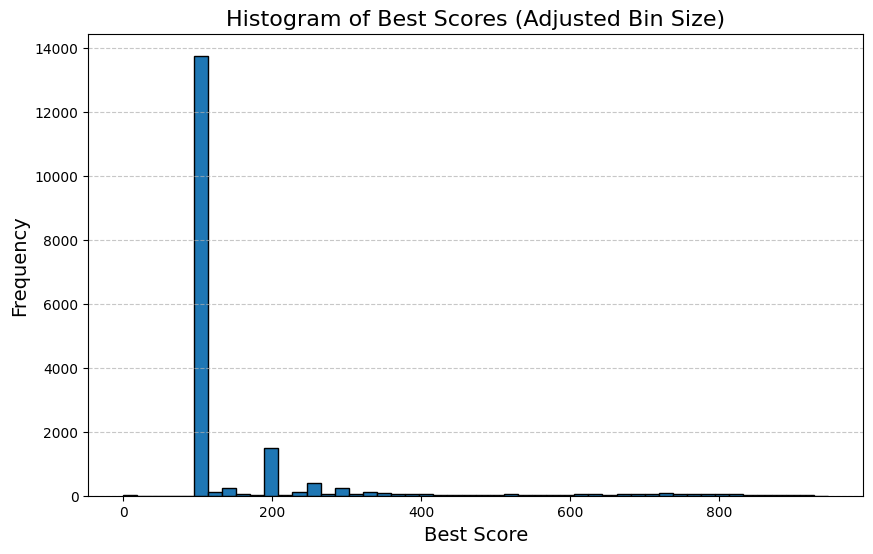

In [102]:
# Adjusted histogram for 'best_score' with more bins
plt.figure(figsize=(10, 6))
plt.hist(df['best_score'], bins=50, edgecolor='black')  # Increased bins to 50
plt.title('Histogram of Best Scores (Adjusted Bin Size)', fontsize=16)
plt.xlabel('Best Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [103]:
# Get the minimum and maximum dates
min_date = df['created_at'].min()
max_date = df['created_at'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2021-02-11 09:22:16
Maximum date: 2022-10-14 14:00:35


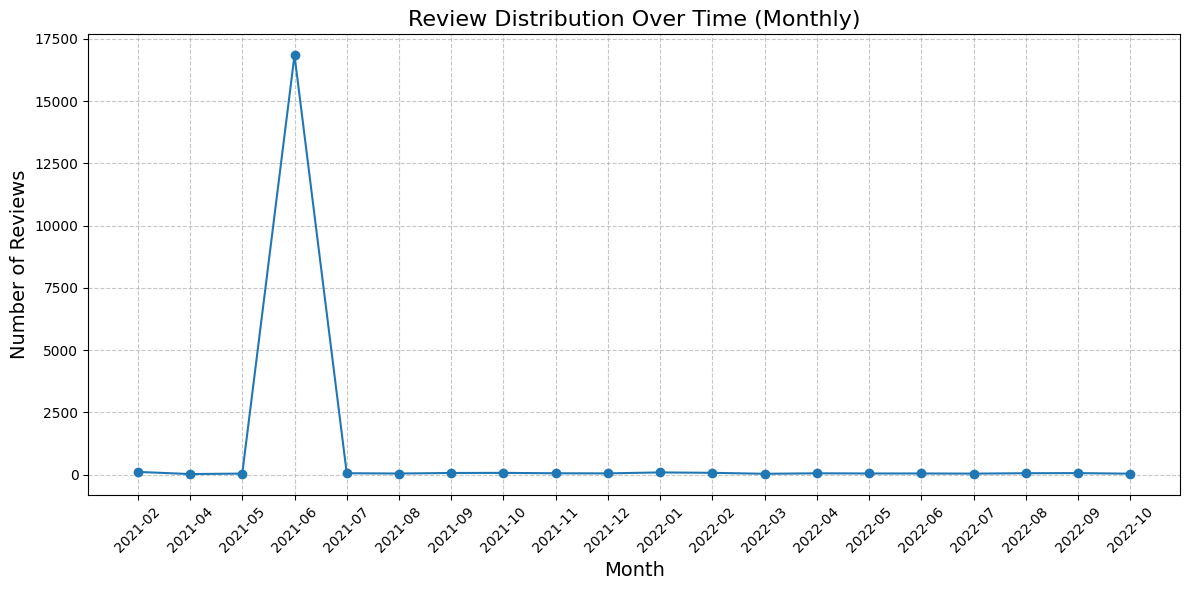

In [104]:
# Group data by month and count reviews
df['month'] = df['created_at'].dt.to_period('M')
monthly_review_distribution = df.groupby('month').size()

# Plot the monthly distribution
plt.figure(figsize=(12, 6))
plt.plot(monthly_review_distribution.index.astype(str), monthly_review_distribution.values, marker='o')
plt.title('Review Distribution Over Time (Monthly)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [105]:
df['user_name'].value_counts()

user_name
2124arizona        28
JGa2595176         27
No_Time_To_Cook    25
mjlouk             25
justmbeth          23
                   ..
Terry_V             1
billt1620           1
jjheath             1
Poeschl             1
cafritz             1
Name: count, Length: 13581, dtype: int64

In [106]:
min_rep = df['user_reputation'].min()
max_rep = df['user_reputation'].max()

print(f"Minimum Rep: {min_rep}")
print(f"Maximum Rep: {max_rep}")

Minimum Rep: 0
Maximum Rep: 520


In [107]:
df['user_reputation'].value_counts()

user_reputation
1      16631
10       652
20       284
0        150
30        74
50        18
40        15
80         9
90         7
60         6
100        5
510        3
110        3
70         3
130        2
140        2
160        1
300        1
220        1
170        1
520        1
150        1
Name: count, dtype: int64

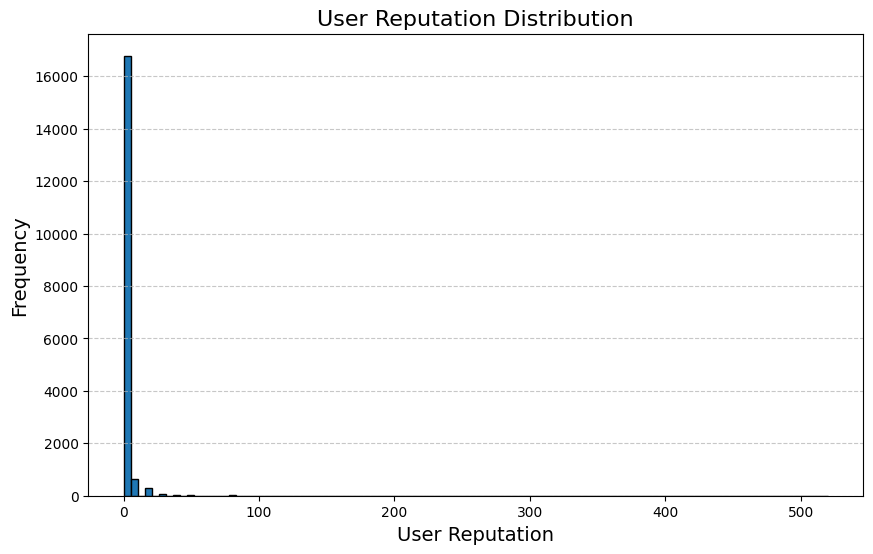

In [108]:
# Plot the histogram for 'user_reputation'
plt.figure(figsize=(10, 6))
plt.hist(df['user_reputation'], bins=100, edgecolor='black')
plt.title('User Reputation Distribution', fontsize=16)
plt.xlabel('User Reputation', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [109]:
# Group by recipe_number and compute summary statistics
summary_stats = df.groupby('recipe_number').agg(
    total_comments=('comment_id', 'count'),       # Count of comments
    avg_user_reputation=('user_reputation', 'mean'),  # Average user reputation
    avg_reply_count=('reply_count', 'mean'),     # Average reply count
    avg_thumbs_up=('thumbs_up', 'mean'),         # Average thumbs up
    avg_thumbs_down=('thumbs_down', 'mean'),     # Average thumbs down
    avg_star_rating=('stars', 'mean'),           # Average star rating
    avg_best_score=('best_score', 'mean')        # Average best score
).reset_index()

# Display the results
summary_stats.head(10)

,recipe_number,total_comments,avg_user_reputation,avg_reply_count,avg_thumbs_up,avg_thumbs_down,avg_star_rating,avg_best_score
0,1,578,1.451557,0.017301,0.574394,0.250865,4.508651,134.769896
1,2,506,2.136364,0.009881,0.322134,0.130435,4.584980,126.377470
2,3,666,1.681682,0.024024,1.102102,0.732733,4.558559,139.584084
3,4,335,3.029851,0.008955,2.892537,0.979104,4.525373,192.319403
4,5,197,1.477157,0.000000,0.131980,0.065990,4.461929,111.751269
5,6,390,1.384615,0.015385,0.933333,0.382051,4.507692,154.500000
6,7,367,1.880109,0.010899,0.787466,0.457766,4.607629,161.021798
7,8,241,1.070539,0.008299,1.286307,1.087137,4.082988,157.103734
8,9,331,1.416918,0.006042,0.625378,0.238671,4.114804,129.833837
9,10,332,2.259036,0.006024,0.638554,0.361446,4.632530,162.746988


In [110]:
# Add a ratio column for thumbs up to thumbs down
summary_stats['thumbs_up_to_down_ratio'] = summary_stats['avg_thumbs_up'] / summary_stats['avg_thumbs_down']

# Handle cases where thumbs down is 0 to avoid division by zero
summary_stats['thumbs_up_to_down_ratio'] = summary_stats['thumbs_up_to_down_ratio'].replace([float('inf'), -float('inf')], None).fillna(0)

# Display the updated summary table
summary_stats.head(10)

,recipe_number,total_comments,avg_user_reputation,avg_reply_count,avg_thumbs_up,avg_thumbs_down,avg_star_rating,avg_best_score,thumbs_up_to_down_ratio
0,1,578,1.451557,0.017301,0.574394,0.250865,4.508651,134.769896,2.289655
1,2,506,2.136364,0.009881,0.322134,0.130435,4.584980,126.377470,2.469697
2,3,666,1.681682,0.024024,1.102102,0.732733,4.558559,139.584084,1.504098
3,4,335,3.029851,0.008955,2.892537,0.979104,4.525373,192.319403,2.954268
4,5,197,1.477157,0.000000,0.131980,0.065990,4.461929,111.751269,2.000000
5,6,390,1.384615,0.015385,0.933333,0.382051,4.507692,154.500000,2.442953
6,7,367,1.880109,0.010899,0.787466,0.457766,4.607629,161.021798,1.720238
7,8,241,1.070539,0.008299,1.286307,1.087137,4.082988,157.103734,1.183206
8,9,331,1.416918,0.006042,0.625378,0.238671,4.114804,129.833837,2.620253
9,10,332,2.259036,0.006024,0.638554,0.361446,4.632530,162.746988,1.766667


In [111]:
summary_stats.tail(10)

,recipe_number,total_comments,avg_user_reputation,avg_reply_count,avg_thumbs_up,avg_thumbs_down,avg_star_rating,avg_best_score,thumbs_up_to_down_ratio
90,91,85,1.329412,0.000000,0.129412,0.023529,3.341176,110.270588,5.500000
91,92,114,4.500000,0.008772,3.114035,1.692982,4.570175,219.684211,1.839378
92,93,109,2.605505,0.000000,0.724771,0.541284,4.321101,150.385321,1.338983
93,94,96,3.197917,0.020833,1.583333,1.197917,4.395833,169.958333,1.321739
94,95,95,3.073684,0.010526,0.821053,0.894737,4.284211,140.326316,0.917647
95,96,109,2.211009,0.000000,0.348624,0.256881,4.440367,143.623853,1.357143
96,97,86,2.430233,0.000000,0.372093,0.220930,3.976744,132.000000,1.684211
97,98,128,6.539062,0.007812,2.992188,1.562500,4.390625,224.265625,1.915000
98,99,112,4.017857,0.000000,1.258929,0.535714,4.258929,188.821429,2.350000
99,100,119,3.336134,0.033613,1.554622,0.789916,4.369748,208.865546,1.968085


In [112]:
top_recipes = df.groupby(['recipe_number', 'recipe_name']).size().reset_index(name='total_comments')
top10 = top_recipes.sort_values(by='recipe_number', ascending=True)

top10.head(10)

,recipe_number,recipe_name,total_comments
0,1,Creamy White Chili,578
1,2,Best Ever Banana Bread,506
2,3,Cheeseburger Soup,666
3,4,Amish Breakfast Casserole,335
4,5,Pumpkin Spice Cupcakes with Cream Cheese Frosting,197
5,6,Favorite Chicken Potpie,390
6,7,Flavorful Chicken Fajitas,367
7,8,Apple Pie,241
8,9,Enchilada Casser-Ole!,331
9,10,Zucchini Pizza Casserole,332


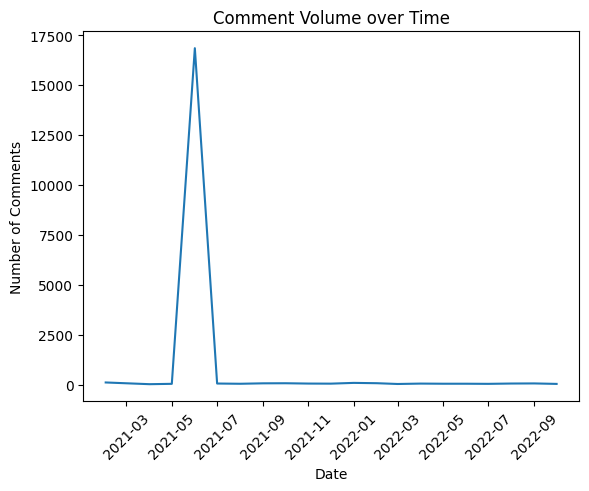

In [113]:
comment_volume = df.groupby(df['created_at'].dt.to_period('M')).size().reset_index(name='comment_count')

plt.plot(comment_volume['created_at'].dt.to_timestamp(), comment_volume['comment_count'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Number of Comments')
plt.title('Comment Volume over Time')
plt.show()

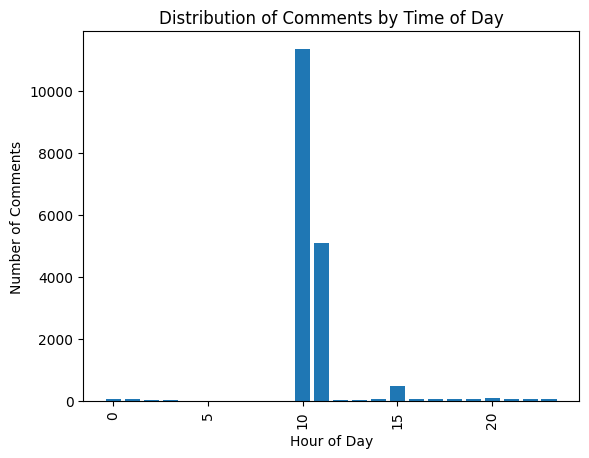

In [114]:
# Majority of comments occur at 10/11 am (Before lunch time to prep the recipe???)

df['hour'] = df['created_at'].dt.hour

hourly_distribution = df.groupby('hour').size().reset_index(name='comment_count')

#Plot the distribution
plt.bar(hourly_distribution['hour'], hourly_distribution['comment_count'])
plt.xlabel('Hour of Day')
plt.xticks(rotation=90)
plt.ylabel('Number of Comments')
plt.title('Distribution of Comments by Time of Day')
plt.show()

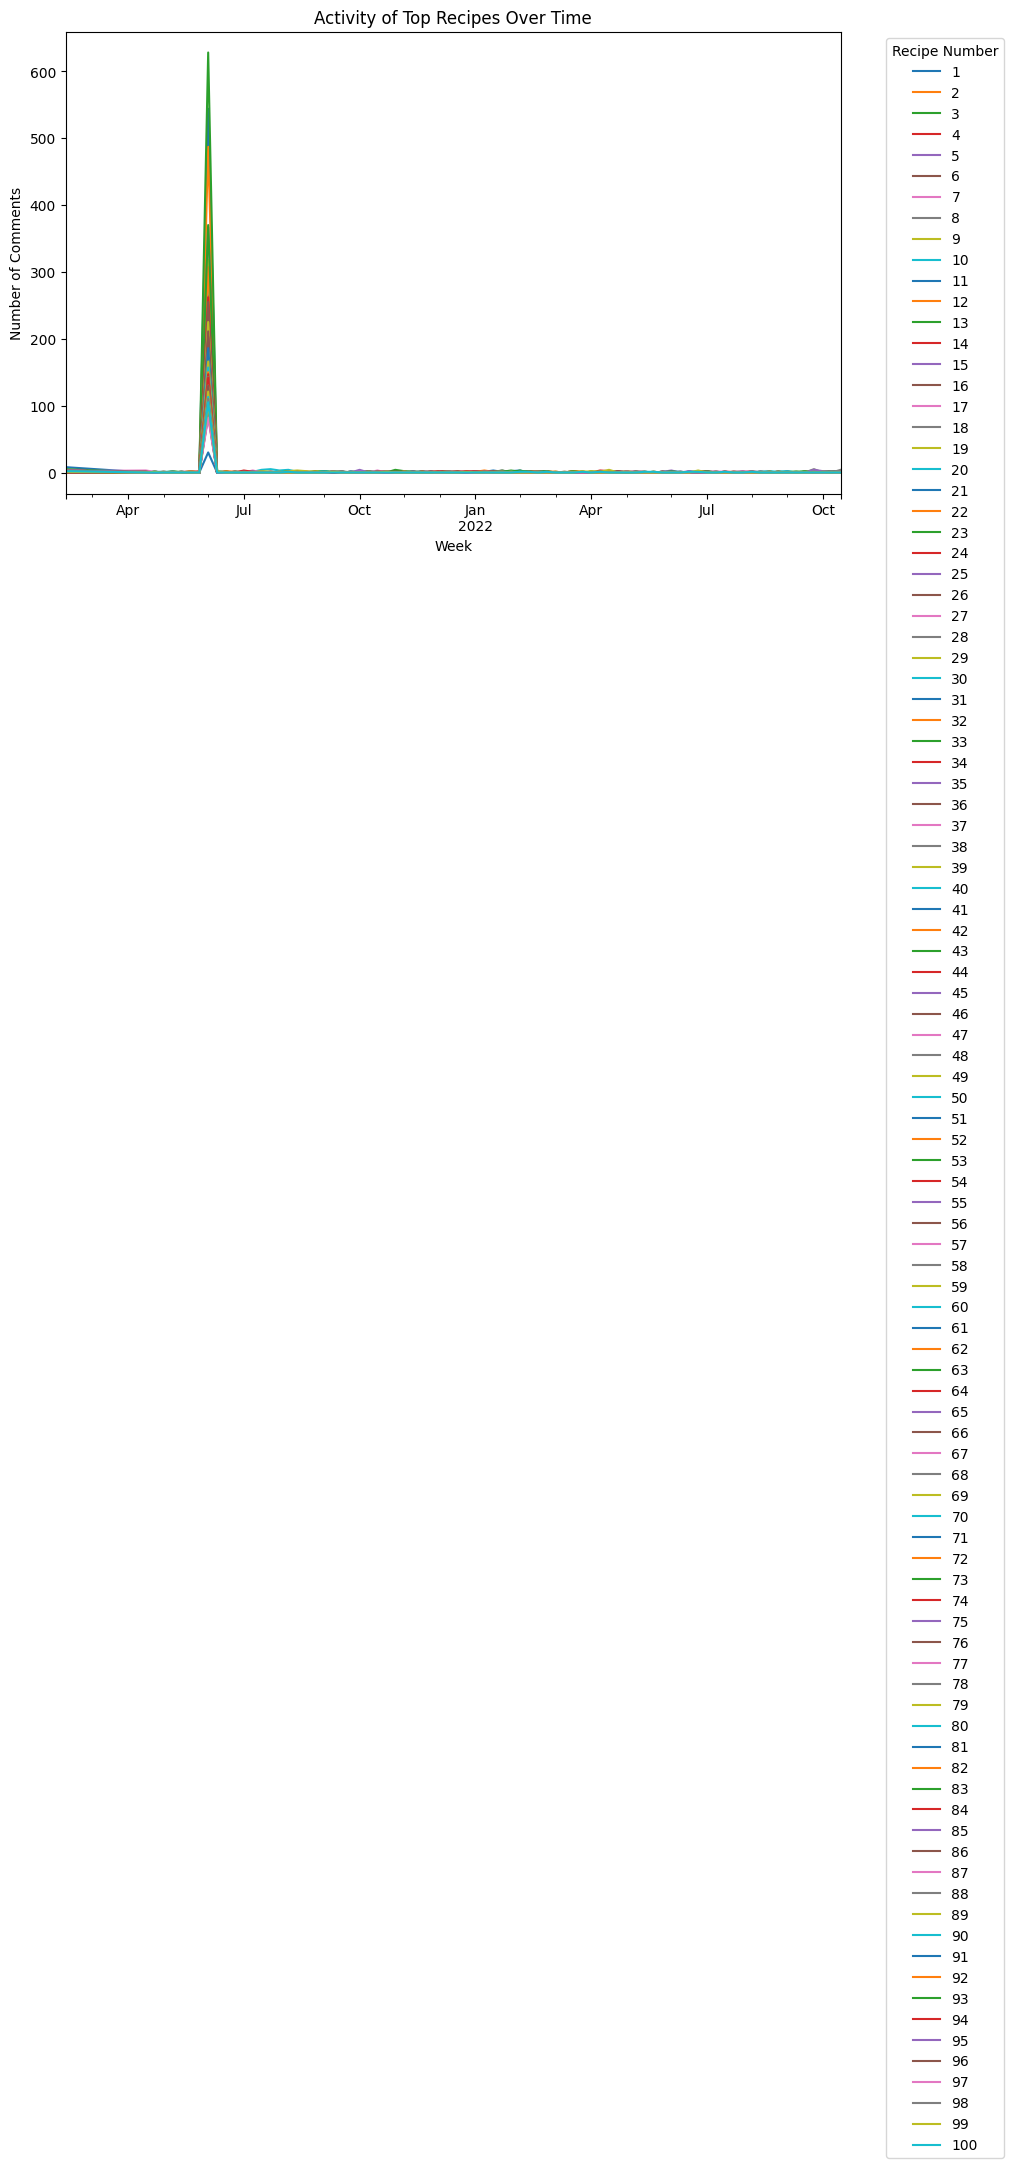

In [115]:
# All the comments were happening in June

# Group by recipe_number and week
recipe_timeline = df.groupby([df['created_at'].dt.to_period('W'), 'recipe_number']).size().unstack(fill_value=0)

# Plot the activity of top recipes
recipe_timeline.plot(figsize=(10, 6))
plt.xlabel('Week')
plt.ylabel('Number of Comments')
plt.title('Activity of Top Recipes Over Time')
plt.legend(title='Recipe Number', bbox_to_anchor=(1.05, 1))
plt.show()

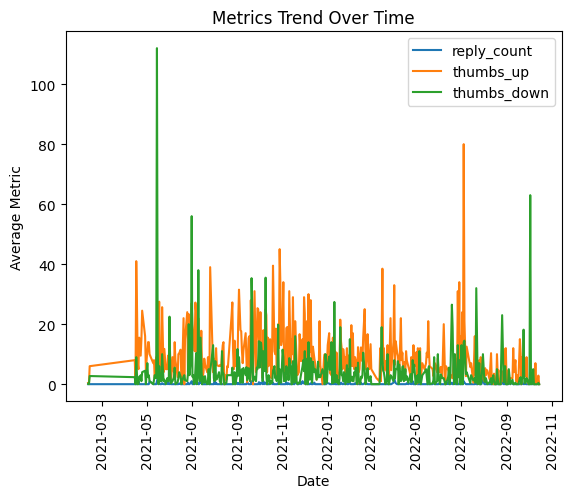

In [116]:
# Group by day and calculate averages
metrics_trend = df.groupby(df['created_at'].dt.to_period('D'))[['reply_count', 'thumbs_up', 'thumbs_down']].mean().reset_index()

# Plot each metric over time
for metric in ['reply_count', 'thumbs_up', 'thumbs_down']:
    plt.plot(metrics_trend['created_at'].dt.to_timestamp(), metrics_trend[metric], label=metric)

plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Average Metric')
plt.title('Metrics Trend Over Time')
plt.legend()
plt.show()

In [117]:
# Sort the dataset by 'thumbs_up' in descending order
top_thumbs_up_comments = df.sort_values(by='thumbs_up', ascending=False)

# Select relevant columns to display (including recipe_number and the full text comment)
top_comments = top_thumbs_up_comments[['recipe_number', 'text', 'thumbs_up']].head(30)

# Display the top comments with the highest thumbs up
top_comments.reset_index()

,index,recipe_number,text,thumbs_up
0,15852,81,goodeasy recipe u snarky bully feel need comme...,106
1,14778,73,fat free half half half half skim milk lot sug...,80
2,13347,62,enjoys review rarely make recipe jawdropping a...,79
3,4191,11,recipe one tends adjust taste said toh altered...,76
4,16497,86,like ingredient portion put together upright m...,76
5,16877,89,remember time long long ago lolwhen mom making...,76
6,4473,12,really liked recipe family make minor change h...,73
7,1192,3,look delicious want make slow cooker anything ...,69
8,3433,9,im always surprised someone change recipe rate...,68
9,17010,90,made company tonight served warm vanilla ice c...,60


In [118]:
# What is the ratio of 5 stars compared to other stars for each recipe

# Count total ratings for each recipe
total_counts = df.groupby('recipe_number').size().reset_index(name='total_ratings')

# Count 5-star ratings for each recipe
five_star_counts = df[df['stars'] == 5].groupby('recipe_number').size().reset_index(name='five_star_count')

# Merge total ratings and 5-star ratings
merged_counts = pd.merge(total_counts, five_star_counts, on='recipe_number', how='left')

# Fill NaN values in five_star_count (for recipes without any 5-star ratings) with 0
merged_counts['five_star_count'] = merged_counts['five_star_count'].fillna(0)

# Calculate the ratio of 5-star ratings to total ratings
merged_counts['five_star_ratio'] = merged_counts['five_star_count'] / merged_counts['total_ratings']

# Display the results
print("Five-Star Ratio for Each Recipe:")
print(merged_counts[['recipe_number', 'five_star_ratio']])

Five-Star Ratio for Each Recipe:
    recipe_number  five_star_ratio
0               1         0.833910
1               2         0.859684
2               3         0.798799
3               4         0.797015
4               5         0.842640
..            ...              ...
95             96         0.752294
96             97         0.651163
97             98         0.773438
98             99         0.660714
99            100         0.739496

[100 rows x 2 columns]


## Sentiment Analysis

The numerical features and textual data provide complementary information that improves the sentiment classification (negative, neutral, or positive). Here’s how they interact and affect the sentiment analysis:

1. Textual Data (TF-IDF)

Textual data captures the semantic content of reviews. Words or phrases often carry direct sentiment information. For example:
	•	Words like “bad,” “terrible,” or “awful” indicate negative sentiment.
	•	Words like “okay” or “average” suggest neutral sentiment.
	•	Words like “excellent,” “amazing,” or “perfect” imply positive sentiment.

By converting this data into TF-IDF vectors, the model learns the importance of specific words in determining the sentiment:
	•	High TF-IDF scores for positive words (e.g., “great,” “love”) lead to higher chances of predicting the review as positive.
	•	Similarly, high TF-IDF scores for negative words (e.g., “poor,” “disappointing”) guide the model toward a negative classification.


2. Numerical Features

Numerical features like approval_rating, user_reputation, reply_count, and best_score provide additional context about the review or reviewer that can influence sentiment prediction:

(a) Approval Rating (approval_rating):
	•	A higher approval rating could correlate with a more positive sentiment.
	•	Example: A user who consistently receives high approval ratings for their reviews is likely to write more positive reviews overall.

(b) User Reputation (user_reputation):
	•	A reviewer with high reputation might have a more critical tone, even in neutral or positive reviews.
	•	Example: A high-reputation user might be more likely to give nuanced feedback, which could alter the sentiment classification.

(c) Reply Count (reply_count):
	•	Reviews with a high reply count might generate stronger sentiments (either positive or negative), as they are more likely to elicit reactions.
	•	Example: A review with many replies could indicate a controversial or strongly worded opinion.

(d) Best Score (best_score):
	•	A high best_score might indicate an exceptional review, likely aligning with positive sentiments.
	•	Example: Reviews with high scores are more likely to be rated positively by other users, implying a positive tone.


3. Effect on the 3 Sentiment Classes

When combined, the numerical features and textual data affect the classification as follows:

Positive Sentiment (4–5 stars)
	•	Text: Words like “excellent,” “love,” or “fantastic” increase the probability of predicting a positive sentiment.
	•	Numerical Features:
	•	High approval_rating reinforces positivity.
	•	High reply_count or best_score adds confidence in the prediction.

Neutral Sentiment (3 stars)
	•	Text: Words like “okay,” “average,” or “fine” suggest neutrality.
	•	Numerical Features:
	•	Moderate approval_rating or user_reputation can help identify neutral reviews.
	•	Low reply_count might indicate less polarizing content.

Negative Sentiment (0–2 stars)
	•	Text: Words like “terrible,” “disappointing,” or “poor” increase the likelihood of negative sentiment classification.
	•	Numerical Features:
	•	Low approval_rating and low best_score further emphasize negative sentiment.

4. How Combined Features Improve Classification

The combination of textual and numerical features creates a richer representation of the reviews:
	•	Textual Data provides context and sentiment-rich signals.
	•	Numerical Features add contextual metadata that may influence sentiment indirectly.

Example:

A review says, “The product is okay but arrived late.”
	•	Text Analysis:
	•	Words like “okay” indicate neutrality, but “arrived late” leans toward negative.
	•	Numerical Data:
	•	If the approval_rating is low and reply_count is high, the classifier might predict a negative sentiment, despite the text being borderline neutral.


In [119]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (replace with your actual dataset if needed)
df = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])  # Ensure no missing values
df = df[df['stars'].between(0, 5)]  # Ensure stars are within valid range

# Map stars to sentiment, with 0 stars as neutral
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

# Apply the updated function
df['sentiment'] = df['stars'].apply(map_star_to_sentiment)

# Encode sentiment labels as integers
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_encoded'] = df['sentiment'].map(label_mapping)

# Preprocess text, numerical features, and labels
texts = df['text'].astype(str).tolist()
approval_ratings = df['approval_rating'].tolist()
user_reputations = df['user_reputation'].tolist()
reply_counts = df['reply_count'].tolist()
best_scores = df['best_score'].tolist()
labels = df['sentiment_encoded'].tolist()

# Classifying Models

Training Random Forest...
Random Forest Accuracy: 0.8606603245663123
Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.07      0.12       102
     neutral       0.62      0.08      0.14       425
    positive       0.87      1.00      0.93      3047

    accuracy                           0.86      3574
   macro avg       0.71      0.38      0.40      3574
weighted avg       0.83      0.86      0.81      3574



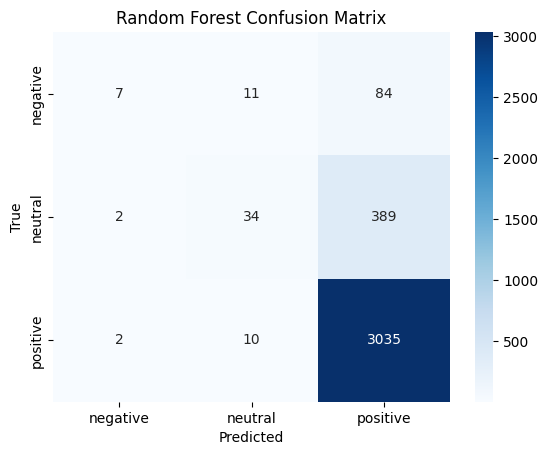

Training Logistic Regression...
Logistic Regression Accuracy: 0.8626189143816452
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.13      0.22       102
     neutral       0.53      0.12      0.19       425
    positive       0.87      0.99      0.93      3047

    accuracy                           0.86      3574
   macro avg       0.71      0.41      0.45      3574
weighted avg       0.83      0.86      0.82      3574



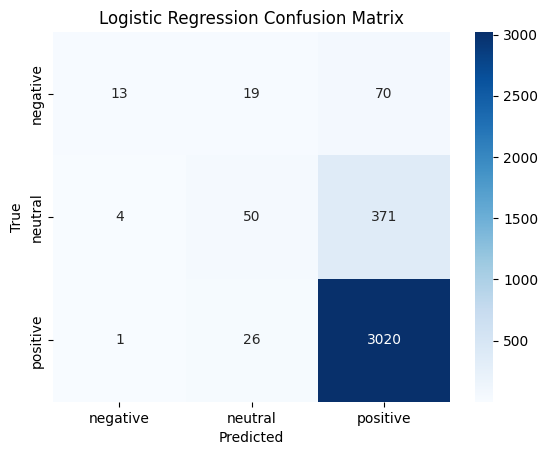

Training Support Vector Machine (SVM)...
Support Vector Machine (SVM) Accuracy: 0.8525461667599329
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       102
     neutral       0.00      0.00      0.00       425
    positive       0.85      1.00      0.92      3047

    accuracy                           0.85      3574
   macro avg       0.28      0.33      0.31      3574
weighted avg       0.73      0.85      0.78      3574



/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

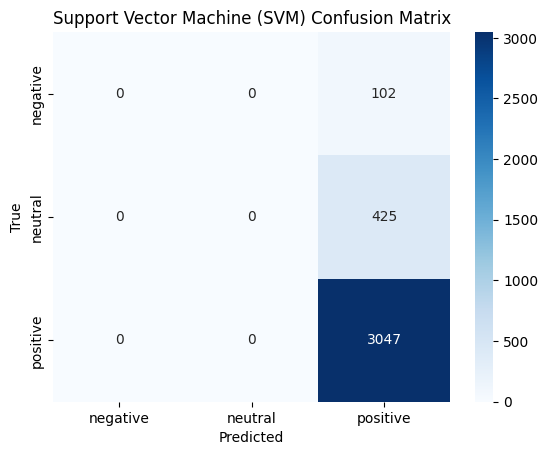


Model Accuracy Summary:
Random Forest: 0.86
Logistic Regression: 0.86
Support Vector Machine (SVM): 0.85


In [120]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing: Use the enhanced sentiment analysis setup
df = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])  # Ensure no missing values
df = df[df['stars'].between(0, 5)]  # Ensure stars are within valid range

# Map stars to sentiment
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

df['sentiment_classifier'] = df['stars'].apply(map_star_to_sentiment)

# Encode sentiment labels as integers
label_mapping_classifier = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_encoded_classifier'] = df['sentiment_classifier'].map(label_mapping_classifier)

# Split dataset
X_text_classifier = df['text'].astype(str)
X_features_classifier = df[['approval_rating', 'user_reputation', 'reply_count', 'best_score']].copy()
y_classifier = df['sentiment_encoded_classifier']

# Split data for training and testing
X_train_text_classifier, X_test_text_classifier, X_train_features_classifier, X_test_features_classifier, y_train_classifier, y_test_classifier = train_test_split(
    X_text_classifier, X_features_classifier, y_classifier, test_size=0.2, random_state=42, stratify=y_classifier
)

# TF-IDF Vectorizer for text
tfidf_vectorizer_classifier = TfidfVectorizer(max_features=5000)
X_train_tfidf_classifier = tfidf_vectorizer_classifier.fit_transform(X_train_text_classifier).toarray()
X_test_tfidf_classifier = tfidf_vectorizer_classifier.transform(X_test_text_classifier).toarray()

# Normalize numerical features
X_train_features_classifier = X_train_features_classifier / X_train_features_classifier.max()
X_test_features_classifier = X_test_features_classifier / X_train_features_classifier.max()

# Combine text and numerical features
X_train_combined_classifier = np.hstack((X_train_tfidf_classifier, X_train_features_classifier))
X_test_combined_classifier = np.hstack((X_test_tfidf_classifier, X_test_features_classifier))

# Model-Specific Features
models_classifier = {
    "Random Forest": {
        "features_train": X_train_combined_classifier,
        "features_test": X_test_combined_classifier,
        "model": RandomForestClassifier(n_estimators=100, random_state=42)
    },
    "Logistic Regression": {
        "features_train": X_train_tfidf_classifier,  # Only text features
        "features_test": X_test_tfidf_classifier,
        "model": LogisticRegression(max_iter=1000, random_state=42)
    },
    "Support Vector Machine (SVM)": {
        "features_train": X_train_features_classifier,  # Only numerical features
        "features_test": X_test_features_classifier,
        "model": SVC(kernel='linear', random_state=42)
    }
}

# Train and Evaluate Models
results_classifier = {}
for model_name, model_info in models_classifier.items():
    print(f"Training {model_name}...")
    model_classifier = model_info["model"]
    X_train_classifier = model_info["features_train"]
    X_test_classifier = model_info["features_test"]

    # Train the model
    model_classifier.fit(X_train_classifier, y_train_classifier)

    # Evaluate the model
    y_pred_classifier = model_classifier.predict(X_test_classifier)
    accuracy_classifier = model_classifier.score(X_test_classifier, y_test_classifier)
    results_classifier[model_name] = accuracy_classifier

    print(f"{model_name} Accuracy: {accuracy_classifier}")
    print("Classification Report:")
    print(classification_report(y_test_classifier, y_pred_classifier, target_names=label_mapping_classifier.keys()))

    # Confusion Matrix
    cm_classifier = confusion_matrix(y_test_classifier, y_pred_classifier)
    sns.heatmap(cm_classifier, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping_classifier.keys(), yticklabels=label_mapping_classifier.keys())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Summary of Model Accuracies
print("\nModel Accuracy Summary:")
for model_name, accuracy in results_classifier.items():
    print(f"{model_name}: {accuracy:.2f}")

1. Random Forest Classifier:
	•	Layers:
	•	Decision Trees: A Random Forest consists of multiple decision trees (e.g., n_estimators=100 means 100 trees are used).
	•	Voting Mechanism: Each tree makes a prediction, and the forest aggregates the results (e.g., majority vote for classification).
	•	Key Components:
	•	Decision splits are made at each tree node based on features.
	•	Predictions are aggregated across all trees in the forest.


2. Logistic Regression:
	•	Layers:
	•	Input Layer: Accepts the TF-IDF text features as input.
	•	Linear Transformation: Applies a linear equation  y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots  to calculate probabilities for each class.
	•	Sigmoid Function (Binary) or Softmax Function (Multiclass): Converts the linear outputs into probabilities.
	•	Key Components:
	•	Uses a probabilistic model to separate classes by fitting a hyperplane in the feature space.

3. Support Vector Machine (SVM):
	•	Layers:
	•	Feature Transformation: Maps the input features (numerical in this case) into a high-dimensional space.
	•	Hyperplane: Finds the optimal hyperplane that separates classes with the largest possible margin.
	•	Support Vectors: Identifies the data points closest to the hyperplane, which influence its position.
	•	Key Components:
	•	Focuses on maximizing the margin between classes.
	•	Works well for linear and non-linear decision boundaries depending on the kernel used (linear in this case).


# Deep Learning Models

## Based on Sentiment

## BiRNN

Testing configuration: units=64, dropout_rate=0.3, learning_rate=0.001
Epoch 1/10


/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_54', 'keras_tensor_57']. Received: the structure of inputs=('*', '*')
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step    accu
Epoch 1: Macro F1 Score = 0.4092
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.8454 - loss: 0.6072 - val_accuracy: 0.8511 - val_loss: 0.4107
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 2: Macro F1 Score = 0.3928
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8714 - loss: 0.3733 - val_accuracy: 0.8539 - val_loss: 0.4067
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  -
Epoch 3: Macro F1 Score = 0.5093
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8945 - loss: 0.3096 - val_accuracy: 0.8593 - val_loss: 0.4128
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 4: Macro F1 Score = 0.5090
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9046 - loss: 0.2838 - val_accuracy: 0.8464 - val_loss: 0.4308
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  - 
Epoch 5: Macro F1 Score = 0.5226
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9219 - loss: 0.2440 - val_accuracy: 0.

/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_62', 'keras_tensor_65']. Received: the structure of inputs=('*', '*')
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step    accura
Epoch 1: Macro F1 Score = 0.3200
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.8363 - loss: 0.6339 - val_accuracy: 0.8458 - val_loss: 0.4105
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  - 
Epoch 2: Macro F1 Score = 0.3990
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8619 - loss: 0.3877 - val_accuracy: 0.8537 - val_loss: 0.4008
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 3: Macro F1 Score = 0.4933
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8772 - loss: 0.3315 - val_accuracy: 0.8551 - val_loss: 0.4154
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 4: Macro F1 Score = 0.4951
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8976 - loss: 0.2888 - val_accuracy: 0.8419 - val_loss: 0.4221
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 5: Macro F1 Score = 0.4966
447/447 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8937 - loss: 0.2890 - val_accuracy: 0.8

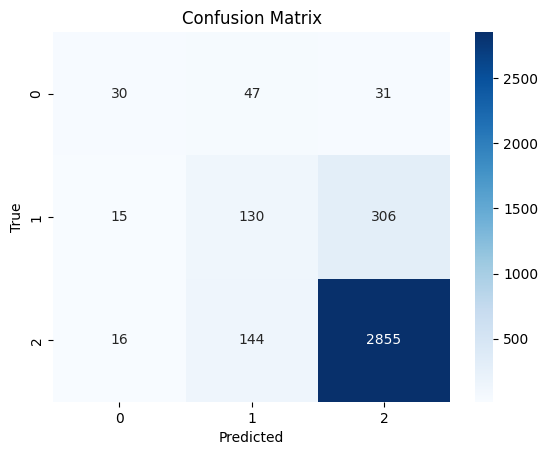

In [121]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Custom Callback to Monitor F1 Score
class F1ScoreCallback(Callback):
    def __init__(self, validation_data, patience=2):
        super().__init__()
        self.validation_data = validation_data
        self.patience = patience
        self.best_f1 = 0
        self.wait = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y_true = self.validation_data
        val_y_pred_probs = self.model.predict(val_x)
        val_y_pred = np.argmax(val_y_pred_probs, axis=1)
        current_f1 = f1_score(val_y_true, val_y_pred, average='macro')
        
        print(f"Epoch {epoch + 1}: Macro F1 Score = {current_f1:.4f}")
        
        # Save the best weights if F1 improves
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered due to no improvement in Macro F1 Score.")
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.best_weights:
            self.model.set_weights(self.best_weights)

# Step 1: Preprocess the dataset
bidir_df = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])
bidir_df = bidir_df[bidir_df['stars'].between(0, 5)]

def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

bidir_df['sentiment'] = bidir_df['stars'].apply(map_star_to_sentiment)
bidir_label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
bidir_df['sentiment_encoded'] = bidir_df['sentiment'].map(bidir_label_mapping)

bidir_texts = bidir_df['text'].astype(str).tolist()
bidir_labels = bidir_df['sentiment_encoded'].tolist()

# Additional numerical features
bidir_approval = bidir_df['approval_rating'].tolist()
bidir_reputation = bidir_df['user_reputation'].tolist()
bidir_reply = bidir_df['reply_count'].tolist()
bidir_score = bidir_df['best_score'].tolist()

# Split data
bidir_X_train_text, bidir_X_test_text, bidir_y_train, bidir_y_test, bidir_X_train_approval, bidir_X_test_approval, \
bidir_X_train_reputation, bidir_X_test_reputation, bidir_X_train_reply, bidir_X_test_reply, \
bidir_X_train_score, bidir_X_test_score = train_test_split(
    bidir_texts, bidir_labels, bidir_approval, bidir_reputation, bidir_reply, bidir_score, 
    test_size=0.2, random_state=42
)

# Normalize numerical features
bidir_X_train_approval = np.array(bidir_X_train_approval).reshape(-1, 1) / 100.0
bidir_X_test_approval = np.array(bidir_X_test_approval).reshape(-1, 1) / 100.0
bidir_X_train_reputation = np.array(bidir_X_train_reputation).reshape(-1, 1) / max(bidir_reputation)
bidir_X_test_reputation = np.array(bidir_X_test_reputation).reshape(-1, 1) / max(bidir_reputation)
bidir_X_train_reply = np.array(bidir_X_train_reply).reshape(-1, 1) / max(bidir_reply)
bidir_X_test_reply = np.array(bidir_X_test_reply).reshape(-1, 1) / max(bidir_reply)
bidir_X_train_score = np.array(bidir_X_train_score).reshape(-1, 1) / max(bidir_score)
bidir_X_test_score = np.array(bidir_X_test_score).reshape(-1, 1) / max(bidir_score)

bidir_X_train_numerical = np.hstack((
    bidir_X_train_approval, bidir_X_train_reputation, bidir_X_train_reply, bidir_X_train_score
))
bidir_X_test_numerical = np.hstack((
    bidir_X_test_approval, bidir_X_test_reputation, bidir_X_test_reply, bidir_X_test_score
))

# Tokenize and pad the text data
bidir_max_vocab_size = 5000
bidir_max_sequence_length = 100

bidir_tokenizer = Tokenizer(num_words=bidir_max_vocab_size, oov_token="<OOV>")
bidir_tokenizer.fit_on_texts(bidir_X_train_text)

bidir_X_train_seq = bidir_tokenizer.texts_to_sequences(bidir_X_train_text)
bidir_X_test_seq = bidir_tokenizer.texts_to_sequences(bidir_X_test_text)

bidir_X_train_padded = pad_sequences(bidir_X_train_seq, maxlen=bidir_max_sequence_length, padding='post', truncating='post')
bidir_X_test_padded = pad_sequences(bidir_X_test_seq, maxlen=bidir_max_sequence_length, padding='post', truncating='post')

# Step 4: Define the BiRNN model
def build_bidir_model_with_numerical(units=64, dropout_rate=0.5, learning_rate=1e-3):
    # Text input and embedding
    text_input = tf.keras.layers.Input(shape=(bidir_max_sequence_length,))
    embedding = tf.keras.layers.Embedding(input_dim=bidir_max_vocab_size, output_dim=64)(text_input)
    birnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False))(embedding)
    
    # Numerical features input
    numerical_input = tf.keras.layers.Input(shape=(bidir_X_train_numerical.shape[1],))
    combined = tf.keras.layers.Concatenate()([birnn, numerical_input])
    
    # Dense and output layers
    dense = tf.keras.layers.Dense(units, activation='relu')(combined)
    dropout = tf.keras.layers.Dropout(dropout_rate)(dense)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout)
    
    model = tf.keras.Model(inputs=[text_input, numerical_input], outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train and evaluate with hyperparameter tuning
best_f1_score = 0
best_params = {}

units_list = [64]
dropout_rates = [0.3, 0.5]
learning_rates = [1e-3]

for units in units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            print(f"Testing configuration: units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            
            bidir_model = build_bidir_model_with_numerical(units, dropout_rate, learning_rate)
            
            f1_callback = F1ScoreCallback(validation_data=(
                [bidir_X_test_padded, bidir_X_test_numerical], bidir_y_test
            ), patience=2)
            
            history = bidir_model.fit(
                [bidir_X_train_padded, bidir_X_train_numerical], np.array(bidir_y_train),
                validation_data=(
                    [bidir_X_test_padded, bidir_X_test_numerical], np.array(bidir_y_test)
                ),
                epochs=10,
                batch_size=32,
                callbacks=[f1_callback],
                verbose=1
            )
            
            bidir_y_pred_probs = bidir_model.predict([bidir_X_test_padded, bidir_X_test_numerical])
            bidir_y_pred = np.argmax(bidir_y_pred_probs, axis=1)
            macro_f1 = f1_score(bidir_y_test, bidir_y_pred, average='macro')
            
            if macro_f1 > best_f1_score:
                best_f1_score = macro_f1
                best_params = {
                    'units': units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate
                }
                best_model = bidir_model

print(f"\nBest Configuration: {best_params}")
print(f"Best Macro F1 Score: {best_f1_score:.4f}")

bidir_y_pred = np.argmax(best_model.predict([bidir_X_test_padded, bidir_X_test_numerical]), axis=1)
print("Classification Report:")
print(classification_report(bidir_y_test, bidir_y_pred))

cm = confusion_matrix(bidir_y_test, bidir_y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

1. Text Input Layer
	•	Input Layer: Input(shape=(bidir_max_sequence_length,))
	•	Accepts sequences of tokenized and padded text data.
	•	Shape: (None, bidir_max_sequence_length), where bidir_max_sequence_length is the maximum length of the padded sequences.

2. Embedding Layer
	•	Embedding: Embedding(input_dim=bidir_max_vocab_size, output_dim=64)
	•	Maps integer-encoded words into dense 64-dimensional vectors.
	•	Input: Tokenized text (integer indices of words).
	•	Output: A 2D tensor (None, bidir_max_sequence_length, 64) where each word is represented by a 64-dimensional vector.

3. Bidirectional RNN Layer
	•	Bidirectional Layer: Bidirectional(LSTM(units, return_sequences=False))
	•	A BiRNN layer that applies a forward and backward LSTM.
	•	units: Number of LSTM units in each direction.
	•	return_sequences=False: Outputs the last hidden state (a single vector for each input sequence).
	•	Output: A vector of size 2 * units due to concatenation of forward and backward states.

4. Numerical Input Layer
	•	Input Layer: Input(shape=(bidir_X_train_numerical.shape[1],))
	•	Accepts numerical features (e.g., approval rating, reputation).
	•	Shape: (None, num_numerical_features).

5. Concatenation Layer
	•	Concatenate: Concatenate()([birnn, numerical_input])
	•	Combines the output of the BiRNN layer (text representation) with the numerical features.
	•	Output: A single concatenated vector.

6. Dense Layer
	•	Dense Layer: Dense(units, activation='relu')
	•	Fully connected layer with units neurons.
	•	Activation: ReLU (Rectified Linear Unit) to introduce non-linearity.
	•	Output: A vector of size units.

7. Dropout Layer
	•	Dropout Layer: Dropout(dropout_rate)
	•	Regularization to prevent overfitting by randomly setting a fraction (dropout_rate) of inputs to zero during training.

8. Output Layer
	•	Dense Layer: Dense(5, activation='softmax')
	•	Fully connected layer with 5 neurons corresponding to the 5 classes (stars rating categories).
	•	Activation: Softmax to output probabilities for each class.

Summary of Input and Outputs:
	•	Input 1: Text sequences (text_input).
	•	Input 2: Numerical features (numerical_input).
	•	Output: Probabilities for each of the 5 classes.

This architecture effectively combines text data (via embeddings and BiRNN) with structured numerical features, making it suitable for tasks where both types of data are important for classification.

## AttBiRNN

Testing configuration: units=64, dropout_rate=0.3, learning_rate=0.001
Epoch 1/10


/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_70', 'keras_tensor_74']. Received: the structure of inputs=('*', '*')
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step    accur
Epoch 1: Macro F1 Score = 0.3051
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8411 - loss: 0.5954 - val_accuracy: 0.8436 - val_loss: 0.4731
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - 
Epoch 2: Macro F1 Score = 0.4572
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8621 - loss: 0.4165 - val_accuracy: 0.8542 - val_loss: 0.4164
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0
Epoch 3: Macro F1 Score = 0.4221
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8744 - loss: 0.3527 - val_accuracy: 0.8553 - val_loss: 0.4034
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 
Epoch 4: Macro F1 Score = 0.5224
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8965 - loss: 0.3016 - val_accuracy: 0.8567 - val_loss: 0.4017
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0
Epoch 5: Macro F1 Score = 0.5394
447/447 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy

/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_79', 'keras_tensor_83']. Received: the structure of inputs=('*', '*')
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step    ac
Epoch 1: Macro F1 Score = 0.3174
447/447 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8381 - loss: 0.6241 - val_accuracy: 0.8447 - val_loss: 0.4216
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0
Epoch 2: Macro F1 Score = 0.3991
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8619 - loss: 0.4034 - val_accuracy: 0.8531 - val_loss: 0.4312
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.
Epoch 3: Macro F1 Score = 0.4729
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.8809 - loss: 0.3438 - val_accuracy: 0.8537 - val_loss: 0.4209
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.
Epoch 4: Macro F1 Score = 0.5280
447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8886 - loss: 0.3253 - val_accuracy: 0.8511 - val_loss: 0.4152
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 
Epoch 5: Macro F1 Score = 0.5185
447/447 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step 

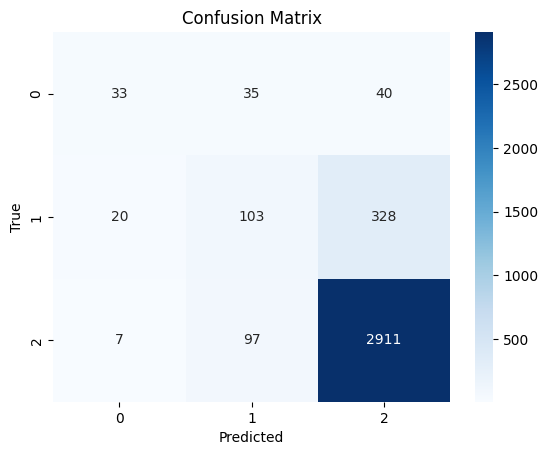

In [122]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.dot(x, self.W)
        e = tf.keras.backend.squeeze(e, axis=-1)
        alpha = tf.keras.backend.softmax(e)
        alpha = tf.keras.backend.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = tf.keras.backend.sum(context, axis=1)
        return context

# Custom Callback to Monitor F1 Score
class F1ScoreCallback(Callback):
    def __init__(self, validation_data, patience=2):
        super().__init__()
        self.validation_data = validation_data
        self.patience = patience
        self.best_f1 = 0
        self.wait = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y_true = self.validation_data
        val_y_pred_probs = self.model.predict(val_x)
        val_y_pred = np.argmax(val_y_pred_probs, axis=1)
        current_f1 = f1_score(val_y_true, val_y_pred, average='macro')
        
        print(f"Epoch {epoch + 1}: Macro F1 Score = {current_f1:.4f}")
        
        # Save the best weights if F1 improves
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered due to no improvement in Macro F1 Score.")
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.best_weights:
            self.model.set_weights(self.best_weights)

# Step 1: Preprocess the dataset
attbirnn_df = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])
attbirnn_df = attbirnn_df[attbirnn_df['stars'].between(0, 5)]

def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

attbirnn_df['sentiment'] = attbirnn_df['stars'].apply(map_star_to_sentiment)
attbirnn_label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
attbirnn_df['sentiment_encoded'] = attbirnn_df['sentiment'].map(attbirnn_label_mapping)

attbirnn_texts = attbirnn_df['text'].astype(str).tolist()
attbirnn_labels = attbirnn_df['sentiment_encoded'].tolist()

# Additional numerical features
attbirnn_approval = attbirnn_df['approval_rating'].tolist()
attbirnn_reputation = attbirnn_df['user_reputation'].tolist()
attbirnn_reply = attbirnn_df['reply_count'].tolist()
attbirnn_score = attbirnn_df['best_score'].tolist()

# Split data
attbirnn_X_train_text, attbirnn_X_test_text, attbirnn_y_train, attbirnn_y_test, attbirnn_X_train_approval, attbirnn_X_test_approval, \
attbirnn_X_train_reputation, attbirnn_X_test_reputation, attbirnn_X_train_reply, attbirnn_X_test_reply, \
attbirnn_X_train_score, attbirnn_X_test_score = train_test_split(
    attbirnn_texts, attbirnn_labels, attbirnn_approval, attbirnn_reputation, attbirnn_reply, attbirnn_score, 
    test_size=0.2, random_state=42
)

# Normalize numerical features
attbirnn_X_train_approval = np.array(attbirnn_X_train_approval).reshape(-1, 1) / 100.0
attbirnn_X_test_approval = np.array(attbirnn_X_test_approval).reshape(-1, 1) / 100.0
attbirnn_X_train_reputation = np.array(attbirnn_X_train_reputation).reshape(-1, 1) / max(attbirnn_reputation)
attbirnn_X_test_reputation = np.array(attbirnn_X_test_reputation).reshape(-1, 1) / max(attbirnn_reputation)
attbirnn_X_train_reply = np.array(attbirnn_X_train_reply).reshape(-1, 1) / max(attbirnn_reply)
attbirnn_X_test_reply = np.array(attbirnn_X_test_reply).reshape(-1, 1) / max(attbirnn_reply)
attbirnn_X_train_score = np.array(attbirnn_X_train_score).reshape(-1, 1) / max(attbirnn_score)
attbirnn_X_test_score = np.array(attbirnn_X_test_score).reshape(-1, 1) / max(attbirnn_score)

attbirnn_X_train_numerical = np.hstack((
    attbirnn_X_train_approval, attbirnn_X_train_reputation, attbirnn_X_train_reply, attbirnn_X_train_score
))
attbirnn_X_test_numerical = np.hstack((
    attbirnn_X_test_approval, attbirnn_X_test_reputation, attbirnn_X_test_reply, attbirnn_X_test_score
))

# Tokenize and pad the text data
attbirnn_max_vocab_size = 5000
attbirnn_max_sequence_length = 100

attbirnn_tokenizer = Tokenizer(num_words=attbirnn_max_vocab_size, oov_token="<OOV>")
attbirnn_tokenizer.fit_on_texts(attbirnn_X_train_text)

attbirnn_X_train_seq = attbirnn_tokenizer.texts_to_sequences(attbirnn_X_train_text)
attbirnn_X_test_seq = attbirnn_tokenizer.texts_to_sequences(attbirnn_X_test_text)

attbirnn_X_train_padded = pad_sequences(attbirnn_X_train_seq, maxlen=attbirnn_max_sequence_length, padding='post', truncating='post')
attbirnn_X_test_padded = pad_sequences(attbirnn_X_test_seq, maxlen=attbirnn_max_sequence_length, padding='post', truncating='post')

# Step 4: Define the AttBiRNN model
def build_attbirnn_model_with_numerical(units=64, dropout_rate=0.5, learning_rate=1e-3):
    # Text input and embedding
    text_input = tf.keras.layers.Input(shape=(attbirnn_max_sequence_length,))
    embedding = tf.keras.layers.Embedding(input_dim=attbirnn_max_vocab_size, output_dim=64)(text_input)
    birnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True))(embedding)
    attention = Attention()(birnn)
    
    # Numerical features input
    numerical_input = tf.keras.layers.Input(shape=(attbirnn_X_train_numerical.shape[1],))
    combined = tf.keras.layers.Concatenate()([attention, numerical_input])
    
    # Dense and output layers
    dense = tf.keras.layers.Dense(units, activation='relu')(combined)
    dropout = tf.keras.layers.Dropout(dropout_rate)(dense)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout)
    
    model = tf.keras.Model(inputs=[text_input, numerical_input], outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Step 5: Train and evaluate with hyperparameter tuning
best_f1_score = 0
best_params = {}

units_list = [64]
dropout_rates = [0.3, 0.5]
learning_rates = [1e-3]

for units in units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            print(f"Testing configuration: units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            
            attbirnn_model = build_attbirnn_model_with_numerical(units, dropout_rate, learning_rate)
            
            f1_callback = F1ScoreCallback(validation_data=(
                [attbirnn_X_test_padded, attbirnn_X_test_numerical], attbirnn_y_test
            ), patience=2)
            
            history = attbirnn_model.fit(
                [attbirnn_X_train_padded, attbirnn_X_train_numerical], np.array(attbirnn_y_train),
                validation_data=(
                    [attbirnn_X_test_padded, attbirnn_X_test_numerical], np.array(attbirnn_y_test)
                ),
                epochs=10,
                batch_size=32,
                callbacks=[f1_callback],
                verbose=1
            )
            
            attbirnn_y_pred_probs = attbirnn_model.predict([attbirnn_X_test_padded, attbirnn_X_test_numerical])
            attbirnn_y_pred = np.argmax(attbirnn_y_pred_probs, axis=1)
            macro_f1 = f1_score(attbirnn_y_test, attbirnn_y_pred, average='macro')
            
            if macro_f1 > best_f1_score:
                best_f1_score = macro_f1
                best_params = {
                    'units': units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate
                }
                best_model = attbirnn_model

print(f"\nBest Configuration: {best_params}")
print(f"Best Macro F1 Score: {best_f1_score:.4f}")

attbirnn_y_pred = np.argmax(best_model.predict([attbirnn_X_test_padded, attbirnn_X_test_numerical]), axis=1)
print("Classification Report:")
print(classification_report(attbirnn_y_test, attbirnn_y_pred))

cm = confusion_matrix(attbirnn_y_test, attbirnn_y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

1. Text Input and Embedding
	1.	Text Input Layer
	•	Input(shape=(attbirnn_max_sequence_length,))
	•	Accepts tokenized and padded text sequences.
	•	Shape: (None, attbirnn_max_sequence_length).
	2.	Embedding Layer
	•	Embedding(input_dim=attbirnn_max_vocab_size, output_dim=64)
	•	Maps integer-encoded words into dense 64-dimensional vectors.
	•	Input: Tokenized text (integer indices of words).
	•	Output: (None, attbirnn_max_sequence_length, 64), where each word is a 64-dimensional vector.

2. Bidirectional RNN with Attention
	3. Bidirectional RNN Layer
	•	Bidirectional(LSTM(units, return_sequences=True))
	•	Applies an LSTM in both forward and backward directions.
	•	return_sequences=True: Outputs hidden states for every time step, enabling attention.
	•	Output: (None, attbirnn_max_sequence_length, 2 * units) (concatenated forward and backward states).
	4. Attention Layer
	•	Attention()
	•	Computes an attention score for each time step of the Bidirectional RNN output.
	•	Attention mechanism highlights relevant parts of the text by weighting them.
	•	Weights (alpha): Learnable attention weights for time steps.
	•	Context Vector: Weighted sum of the RNN outputs across all time steps.
	•	Output: (None, 2 * units) (context vector summarizing the sequence).

3. Numerical Features Input
	5. Numerical Input Layer
	•	Input(shape=(attbirnn_X_train_numerical.shape[1],))
	•	Accepts numerical features like approval_rating, user_reputation, etc.
	•	Shape: (None, num_numerical_features).

4. Combining Text and Numerical Features
	6. Concatenation Layer
	•	Concatenate()([attention, numerical_input])
	•	Combines the context vector from the attention layer with numerical features.
	•	Output: A single vector of size 2 * units + num_numerical_features.

5. Fully Connected Layers
	7. Dense Layer
	•	Dense(units, activation='relu')
	•	Fully connected layer with units neurons.
	•	Activation: ReLU introduces non-linearity.
	•	Output: A vector of size units.
	8. Dropout Layer
	•	Dropout(dropout_rate)
	•	Randomly sets a fraction of inputs to zero for regularization.
	
6. Output Layer
	9. Dense Output Layer
	•	Dense(5, activation='softmax')
	•	Fully connected layer with 5 neurons, corresponding to 5 sentiment classes.
	•	Activation: Softmax converts outputs into class probabilities.
	•	Output: Probability distribution over 5 classes.

Summary of Inputs and Outputs
	•	Input 1: Text sequences (text_input).
	•	Input 2: Numerical features (numerical_input).
	•	Output: Probabilities for each of the 5 classes.

Significance of the Attention Mechanism

The attention layer enables the model to focus on the most relevant parts of the text sequence, effectively enhancing performance in tasks where specific words or phrases are critical for classification. This makes the model more interpretable and context-aware.

## LSTM

Reloading Tuner from /var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/lstm_sentiment_tuning_with_num/tuner0.json

The optimal embedding dimension is 128,
with 128 LSTM units,
64 units in the dense layer,
dropout of 0.2,
and learning rate of 0.0006829509394214718.

Epoch 1/5


/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'numerical_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8498 - loss: 0.5571 - val_accuracy: 0.8549 - val_loss: 0.4938
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.8555 - loss: 0.4897 - val_accuracy: 0.8549 - val_loss: 0.4905
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8563 - loss: 0.4894 - val_accuracy: 0.8549 - val_loss: 0.4878
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8531 - loss: 0.4934 - val_accuracy: 0.8549 - val_loss: 0.4858
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8585 - loss: 0.4764 - val_accuracy: 0.8549 - val_loss: 0.4876
Test Accuracy: 0.8435925841331482
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Macro F1-Score: 0.3050538776749127


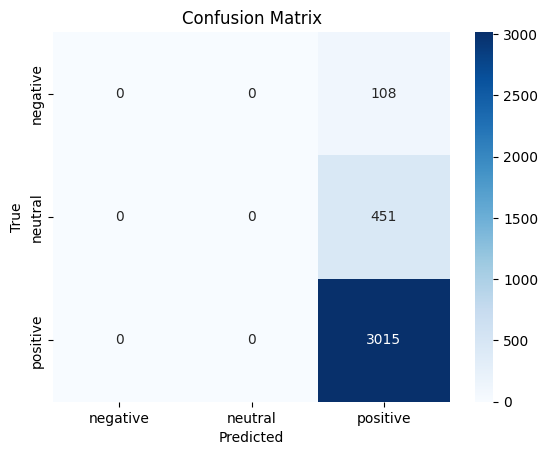

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       108
     neutral       0.00      0.00      0.00       451
    positive       0.84      1.00      0.92      3015

    accuracy                           0.84      3574
   macro avg       0.28      0.33      0.31      3574
weighted avg       0.71      0.84      0.77      3574



/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [123]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

# Step 1: Data Preparation
# Clean and process the original DataFrame `df`
df = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])
df = df[df['stars'].between(0, 5)]  # Ensure stars are within valid range

# Map stars to sentiment
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

df['sentiment'] = df['stars'].apply(map_star_to_sentiment)

# Encode sentiment labels
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_encoded'] = df['sentiment'].map(label_mapping)

# Extract features and labels
texts = df['text'].astype(str).tolist()
approval_ratings = df['approval_rating'].tolist()
user_reputations = df['user_reputation'].tolist()
reply_counts = df['reply_count'].tolist()
best_scores = df['best_score'].tolist()
labels = df['sentiment_encoded'].tolist()

# Split the data into training and testing sets
X_train_text, X_test_text, X_train_rating, X_test_rating, X_train_reputation, X_test_reputation, X_train_reply, X_test_reply, X_train_score, X_test_score, y_train_lstm_combined, y_test_lstm_combined = train_test_split(
    texts, approval_ratings, user_reputations, reply_counts, best_scores, labels, test_size=0.2, random_state=42
)

# Tokenize and Pad Text Data
vocab_size = 5000
max_seq_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post')

# Normalize numerical features
X_train_rating = np.array(X_train_rating).reshape(-1, 1) / 100.0
X_test_rating = np.array(X_test_rating).reshape(-1, 1) / 100.0
X_train_reputation = np.array(X_train_reputation).reshape(-1, 1) / df['user_reputation'].max()
X_test_reputation = np.array(X_test_reputation).reshape(-1, 1) / df['user_reputation'].max()
X_train_reply = np.array(X_train_reply).reshape(-1, 1) / df['reply_count'].max()
X_test_reply = np.array(X_test_reply).reshape(-1, 1) / df['reply_count'].max()
X_train_score = np.array(X_train_score).reshape(-1, 1) / df['best_score'].max()
X_test_score = np.array(X_test_score).reshape(-1, 1) / df['best_score'].max()

# Combine numerical features into a single array
X_train_numerical = np.hstack((X_train_rating, X_train_reputation, X_train_reply, X_train_score))
X_test_numerical = np.hstack((X_test_rating, X_test_reputation, X_test_reply, X_test_score))

# Use a subset of the data for hyperparameter tuning
subset_size = len(X_train_padded) // 2
X_train_subset_text = X_train_padded[:subset_size]
X_train_subset_num = X_train_numerical[:subset_size]
y_train_subset_lstm_combined = y_train_lstm_combined[:subset_size]

# Step 2: Define the Model for Tuning
def build_lstm_model(hp):
    text_input = Input(shape=(max_seq_len,), name="text_input")
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int("embedding_dim", min_value=64, max_value=128, step=64),
        input_length=max_seq_len
    )(text_input)
    lstm_layer = LSTM(
        units=hp.Int("lstm_units", min_value=64, max_value=128, step=64),
        return_sequences=False
    )(embedding_layer)
    
    numerical_input = Input(shape=(4,), name="numerical_input")
    concatenated = Concatenate()([lstm_layer, numerical_input])
    
    dense_layer = Dense(
        units=hp.Int("dense_units", min_value=64, max_value=128, step=64),
        activation="relu"
    )(concatenated)
    dropout_layer = Dropout(hp.Float("dropout", min_value=0.2, max_value=0.3, step=0.1))(dense_layer)
    output_layer = Dense(3, activation="softmax")(dropout_layer)

    model = tf.keras.models.Model(inputs=[text_input, numerical_input], outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, sampling="log")
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Step 3: Hyperparameter Tuning with Keras Tuner
temp_dir = tempfile.gettempdir()
tuner = kt.Hyperband(
    build_lstm_model,
    objective="val_loss",
    max_epochs=5,
    factor=4,
    directory=temp_dir,
    project_name="lstm_sentiment_tuning_with_num"
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

tuner.search(
    [X_train_subset_text, X_train_subset_num],
    np.array(y_train_subset_lstm_combined),
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Step 4: Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal embedding dimension is {best_hps.get('embedding_dim')},
with {best_hps.get('lstm_units')} LSTM units,
{best_hps.get('dense_units')} units in the dense layer,
dropout of {best_hps.get('dropout')},
and learning rate of {best_hps.get('learning_rate')}.
""")

# Step 5: Train the Best Model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    [X_train_padded, X_train_numerical],
    np.array(y_train_lstm_combined),
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model
test_loss_lstm_combined, test_accuracy_lstm_combined = best_model.evaluate(
    [X_test_padded, X_test_numerical], 
    np.array(y_test_lstm_combined), 
    verbose=0
)
print(f"Test Accuracy: {test_accuracy_lstm_combined}")

# Step 7: Predictions and Metrics
y_pred_lstm_combined = np.argmax(best_model.predict([X_test_padded, X_test_numerical]), axis=1)

# Compute macro F1-score
macro_f1_lstm_combined = f1_score(y_test_lstm_combined, y_pred_lstm_combined, average='macro')
print(f"Macro F1-Score: {macro_f1_lstm_combined}")

# Confusion Matrix
cm_lstm_combined = confusion_matrix(y_test_lstm_combined, y_pred_lstm_combined)
sns.heatmap(cm_lstm_combined, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_lstm_combined, y_pred_lstm_combined, target_names=label_mapping.keys()))

1. Data Preparation
	•	Clean and Process Dataset:
	•	Removed rows with missing values in relevant columns: text, stars, approval_rating, user_reputation, reply_count, best_score.
	•	Filtered rows to ensure stars values are between 0 and 5.
	•	Sentiment Mapping:
	•	Stars ≤ 2 → “negative”, Star = 3 → “neutral”, Stars ≥ 4 → “positive”.
	•	Encoded sentiments into numerical values: 0 = negative, 1 = neutral, 2 = positive.
	•	Splitting Data:
	•	Used train_test_split to separate data into training and testing sets.
	•	Extracted and normalized additional numerical features: approval_rating, user_reputation, reply_count, best_score.
	•	Text Tokenization and Padding:
	•	Tokenized text data with a vocabulary size of 5000.
	•	Padded sequences to a maximum length of 100 tokens.

2. Model Definition
	•	Text Input and Embedding:
            Input layer for tokenized text.
            Embedding layer with a tunable dimension (64 to 128).
	•	LSTM Layer:
	        Bidirectional LSTM with tunable units (64 to 128).
	        Outputs a representation of text data.
	•	Numerical Input:
	        Separate input for numerical features (4 features normalized between 0 and 1).
	•	Dense Layers and Output:
	        Concatenation of LSTM output and numerical features.
	        Dense layer with tunable units (64 to 128) and dropout (0.2 to 0.3).
	        Output layer with 3 neurons (softmax for sentiment classification).
			
3. Hyperparameter Tuning
	•	Used Keras Tuner (Hyperband) for automated hyperparameter search:
	•	Tunable parameters:
	•	Embedding dimension: 64 to 128.
	•	LSTM units: 64 to 128.
	•	Dense layer units: 64 to 128.
	•	Dropout rate: 0.2 to 0.3.
	•	Learning rate: 1e-4 to 1e-3.
	•	Objective: Minimize validation loss.
	•	Performed search on a subset of the training data with validation split.


## Star Ratings

### Text classification model built using a Deep Neural Network (DNN) architecture with an Embedding Layer and a Global Average Pooling Layer.

Epoch 1/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - loss: 0.8658 - val_loss: 0.6054
Epoch 2/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.6804 - val_loss: 0.5963
Epoch 3/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.6515 - val_loss: 0.5886
Epoch 4/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.6316 - val_loss: 0.5628
Epoch 5/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.6024 - val_loss: 0.5363
Epoch 6/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 0.5691 - val_loss: 0.5081
Epoch 7/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.5190 - val_loss: 0.4864
Epoch 8/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 0.5005 - val_loss: 0.4872
Epoch 9/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.4830 - val_loss: 0.4939
Epoch 10/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 0.4789 - val_loss: 0.4856
Epoch 11/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 0.4665 - val_loss: 0.4991
Epoch 12/20
406/406 ━━━━━━━━━━

/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

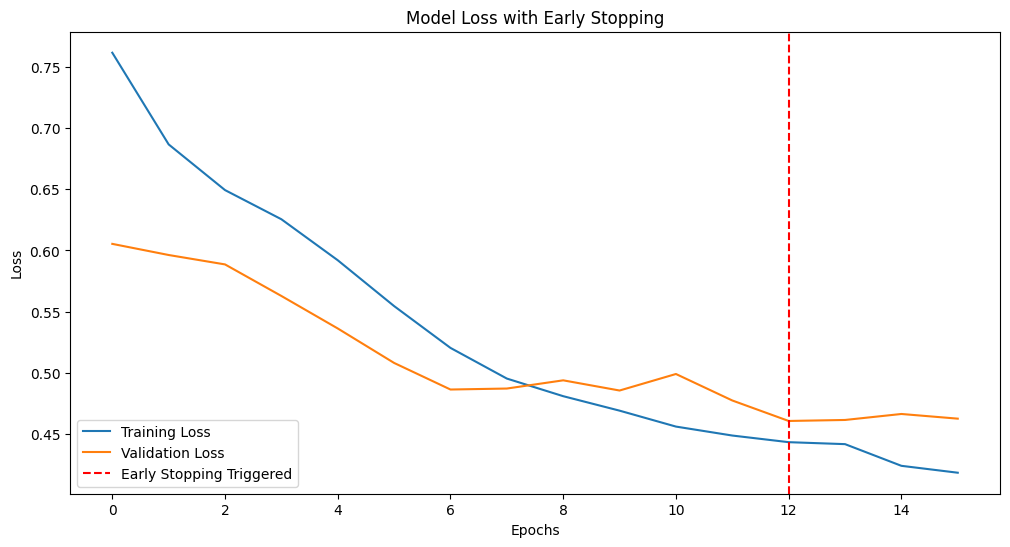

In [124]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Filter valid data
df = df.dropna(subset=['text', 'stars'])
df = df[df['stars'].between(1, 5)]  # Ensure stars values are between 1 and 5

# Step 2: Preprocess the text data
dnn_texts = df['text'].astype(str)
dnn_labels = df['stars']

# Step 3: Split the dataset
dnn_X_train, dnn_X_test, dnn_y_train, dnn_y_test = train_test_split(
    dnn_texts, dnn_labels, test_size=0.2, random_state=42
)

# Step 4: Tokenize text data
dnn_tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
dnn_tokenizer.fit_on_texts(dnn_X_train)

dnn_X_train_seq = dnn_tokenizer.texts_to_sequences(dnn_X_train)
dnn_X_test_seq = dnn_tokenizer.texts_to_sequences(dnn_X_test)

# Step 5: Pad sequences
dnn_max_len = 100
dnn_X_train_padded = pad_sequences(dnn_X_train_seq, maxlen=dnn_max_len, padding='post', truncating='post')
dnn_X_test_padded = pad_sequences(dnn_X_test_seq, maxlen=dnn_max_len, padding='post', truncating='post')

# Convert labels to 0-indexed (since stars are 1-5, subtract 1)
dnn_y_train = dnn_y_train - 1
dnn_y_test = dnn_y_test - 1

# Step 6: Build the model
dnn_num_classes = 5

dnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(dnn_num_classes, activation='softmax')  # Softmax for multi-class output
])

dnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Multi-class loss function
                  metrics=[])  # Remove accuracy to calculate F1-score separately

# Step 7: Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Step 8: Train the model
dnn_history = dnn_model.fit(
    dnn_X_train_padded, 
    dnn_y_train, 
    epochs=20,  # Set a higher number of epochs
    validation_data=(dnn_X_test_padded, dnn_y_test),
    batch_size=32,
    callbacks=[early_stopping]  # Add the early stopping callback
)

# Step 9: Evaluate the model
# Predict classes for the test set
dnn_y_test_pred_probs = dnn_model.predict(dnn_X_test_padded)
dnn_y_test_pred = tf.argmax(dnn_y_test_pred_probs, axis=1).numpy()

# Classification Report
dnn_class_report = classification_report(dnn_y_test, dnn_y_test_pred, target_names=[str(i) for i in range(1, 6)])
print("\nClassification Report:")
print(dnn_class_report)

# Calculate F1-score
dnn_f1 = f1_score(dnn_y_test, dnn_y_test_pred, average='weighted')
print(f"Test F1-Score: {dnn_f1:.4f}")

# Step 10: Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(dnn_history.history['loss'], label='Training Loss')
plt.plot(dnn_history.history['val_loss'], label='Validation Loss')
plt.axvline(x=len(dnn_history.history['loss']) - early_stopping.patience - 1, color='red', linestyle='--', label='Early Stopping Triggered')
plt.title('Model Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The “loss” represents how far off the model’s predictions are from the true labels. Specifically:
	•	Training Loss: Measures the error the model makes on the training data.
	•	Validation Loss: Measures the error the model makes on unseen (validation) data.
    
The graph shows that both training and validation loss decrease over time, meaning the model is learning effectively.

The validation loss is slightly higher than the training loss, which is normal and indicates the model generalizes well. Since the losses flatten at the end and there’s no large gap, the model is not overfitting.

The DNN has a sequential architecture, and its layers are as follows:
1.	Embedding Layer:
	•	Input: Sequences of integers representing tokenized words (from the Tokenizer).
	•	Function: Converts each word index into a dense vector of a fixed size (embedding dimension = 16 in this case).
	•	Purpose: Captures semantic relationships between words in a continuous vector space.
	•	Layer Details:
	•	Input dimension: 10000 (vocabulary size).
	•	Output dimension: 16 (embedding size for each word).

2.	Global Average Pooling 1D Layer:
	•	Input: The output of the Embedding layer (a 2D tensor with word embeddings).
	•	Function: Averages the embeddings across all words in a sequence, producing a single vector for each input sequence.
	•	Purpose: Reduces the sequence into a fixed-size vector, regardless of the input length.

3.	Dense Layer:
	•	Input: The pooled embeddings.
	•	Function: Applies a fully connected layer with 16 neurons and a ReLU activation function.
	•	Purpose: Learns higher-level feature representations of the input.

4.	Dropout Layer:
	•	Function: Randomly sets 50% of the neurons to zero during training.
	•	Purpose: Prevents overfitting by introducing regularization.

5.	Dense Output Layer:
	•	Input: The output from the Dense and Dropout layers.
	•	Function: Applies a fully connected layer with 5 neurons (one for each class) and a softmax activation.
	•	Purpose: Outputs the probability distribution over the 5 classes (corresponding to star ratings 1 to 5).

## Bi-Directional LSTM for Specific Recipe

Epoch 1/10


/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - loss: 1.6141 - val_loss: 1.5473
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.5416 - val_loss: 1.4130
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.4056 - val_loss: 1.1747
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.1714 - val_loss: 0.8372
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.8572 - val_loss: 0.5660
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.6464 - val_loss: 0.4516
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5698 - val_loss: 0.4357
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.5934 - val_loss: 0.4531
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.5515 - val_loss: 0.4729
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5043 - val_loss: 0.4909
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Caramel Heavenlies Model Test F1-Score: 0.8768

Caramel Heavenlies Model Classification Report
              precision    recall  f1-score  

/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

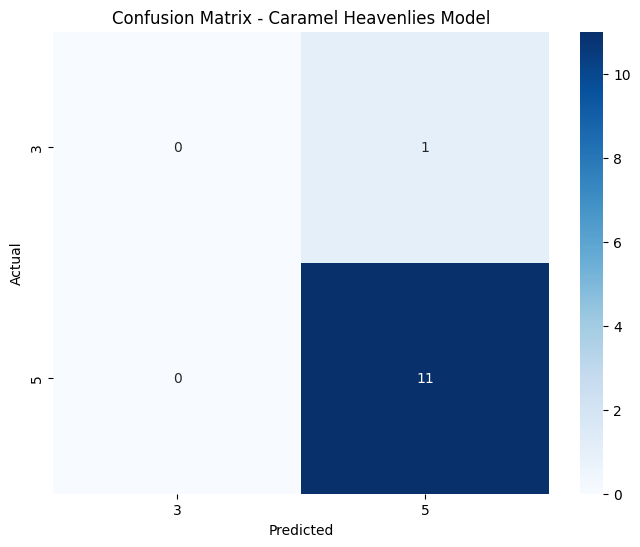

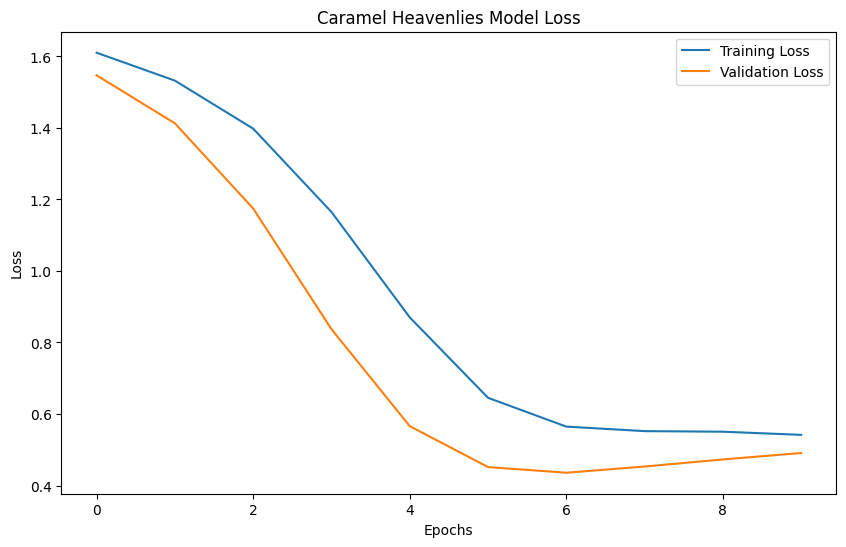

In [125]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the DataFrame for the specific recipe
df_specific = df.copy()

# Filter for the specific recipe
specific_recipe = "Caramel Heavenlies"
df_specific = df_specific.dropna(subset=['text', 'stars', 'recipe_name'])
df_specific = df_specific[df_specific['stars'].between(1, 5)]
df_specific = df_specific[df_specific['recipe_name'] == specific_recipe]

# Check if there are enough reviews for the recipe
if df_specific.shape[0] < 1:
    raise ValueError(f"No reviews found for the recipe '{specific_recipe}'.")

# Preprocess the text and labels
texts_specific = df_specific['text'].astype(str)
labels_specific = df_specific['stars']

# Handle small datasets
if df_specific.shape[0] < 2:
    print(f"Warning: Only {df_specific.shape[0]} review(s) found for '{specific_recipe}'.")
    X_train, X_test, y_train, y_test = texts_specific, texts_specific, labels_specific, labels_specific
else:
    X_train, X_test, y_train, y_test = train_test_split(
        texts_specific, labels_specific, test_size=0.2, random_state=42
    )

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 150
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Convert labels to 0-indexed
y_train = y_train - 1
y_test = y_test - 1

# Step 2: Build and Train the LSTM Model
num_classes = 5
model_specific = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_specific.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=[])

# Train the model
history_specific = model_specific.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_test_padded, y_test),
    batch_size=32
)

# Step 3: Evaluate with F1-Score
# Predict and generate predicted classes
y_pred_probs = model_specific.predict(X_test_padded)
y_pred_classes = y_pred_probs.argmax(axis=-1)

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"{specific_recipe} Model Test F1-Score: {f1:.4f}")

# Step 4: Classification Report
# Dynamically set target names based on unique classes
unique_classes = sorted(y_test.unique())
target_names = [str(label + 1) for label in unique_classes]  # Adjust to match star ratings

print(f"\n{specific_recipe} Model Classification Report")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Step 5: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {specific_recipe} Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 6: Visualize Training and Validation Metrics
# Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_specific.history['loss'], label='Training Loss')
plt.plot(history_specific.history['val_loss'], label='Validation Loss')
plt.title(f'{specific_recipe} Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1.	Embedding Layer:
	•	Input: Tokenized and padded sequences of text (each word represented as an integer).
	•	Function: Converts word indices into dense vectors of size 64.
	•	Purpose: Encodes semantic relationships between words into continuous vector space.
	•	Parameters:
	•	Input dimension: 10,000 (vocabulary size).
	•	Output dimension: 64 (embedding size for each word).
	•	Input length: 150 (maximum sequence length).

2.	Bidirectional LSTM Layer 1:
	•	Input: Word embeddings for each sequence.
	•	Function: A Bidirectional LSTM processes the input sequence both forward and backward, capturing contextual information from both directions.
	•	Output: Sequences of hidden states (one for each timestep).
	•	Units: 64 LSTM units in each direction (128 combined).

3.	Bidirectional LSTM Layer 2:
	•	Input: The output of the first LSTM layer.
	•	Function: Similar to the first layer but returns only the final hidden states.
	•	Units: 32 LSTM units in each direction (64 combined).
	•	Purpose: Further condenses sequence information into a single vector.

4.	Dense Layer:
	•	Input: The final hidden state from the second LSTM layer.
	•	Function: Fully connected layer with 32 neurons and ReLU activation.
	•	Purpose: Learns high-level feature representations for classification.

5.	Output Layer:
	•	Input: The output of the dense layer.
	•	Function: Fully connected layer with 5 neurons and softmax activation.
	•	Purpose: Outputs a probability distribution over the 5 classes (1 to 5 stars).

# NLP

## Based on Sentiment Analysis

### TF-IDF

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 811
max_resources_: 12979
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 27
n_resources: 811
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 1
n_candidates: 14
n_resources: 1622
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 7
n_resources: 3244
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 4
n_resources: 6488
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 12976
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Iteration 1: Macro F1 Score = 0.3225
Iteration 2: Macro F1 Score = 0.3225
Iteration 3: Macro F1 Score = 0.3225
Iteration 4: Macro F1 Score = 0.3225
Early stopping triggered during hyperparameter tuning.
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_spl

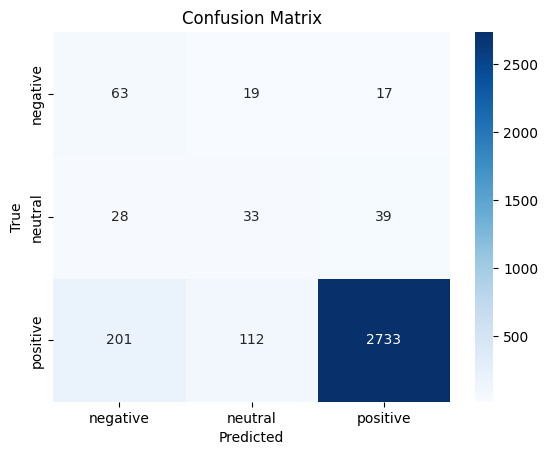

Classification Report:
              precision    recall  f1-score   support

    negative       0.22      0.64      0.32        99
     neutral       0.20      0.33      0.25       100
    positive       0.98      0.90      0.94      3046

    accuracy                           0.87      3245
   macro avg       0.47      0.62      0.50      3245
weighted avg       0.93      0.87      0.90      3245



In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv  # Enable HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data cleaning and preprocessing
rf_model_df = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])
rf_model_df = rf_model_df[rf_model_df['stars'].between(0, 5)]  # Ensure stars are within valid range

# Map stars to sentiment categories
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

rf_model_df['sentiment'] = rf_model_df['stars'].apply(map_star_to_sentiment)

# Encode sentiment labels into integers
rf_sentiment_label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
rf_model_df['sentiment_encoded'] = rf_model_df['sentiment'].map(rf_sentiment_label_mapping)

# Extract features and labels
rf_model_texts = rf_model_df['text'].astype(str).tolist()
rf_model_approval_ratings = rf_model_df['approval_rating'].tolist()
rf_model_user_reputation = rf_model_df['user_reputation'].tolist()
rf_model_reply_count = rf_model_df['reply_count'].tolist()
rf_model_best_score = rf_model_df['best_score'].tolist()
rf_model_labels = rf_model_df['sentiment_encoded'].tolist()

# Split the data into training and testing sets
rf_train_texts, rf_test_texts, rf_train_approval_ratings, rf_test_approval_ratings, rf_train_reputation, rf_test_reputation, \
rf_train_reply_count, rf_test_reply_count, rf_train_best_score, rf_test_best_score, rf_train_labels, rf_test_labels = train_test_split(
    rf_model_texts, rf_model_approval_ratings, rf_model_user_reputation, rf_model_reply_count, rf_model_best_score, rf_model_labels,
    test_size=0.2, random_state=42
)

# Text feature extraction using TF-IDF
rf_tfidf_vectorizer = TfidfVectorizer(max_features=5000)
rf_train_tfidf_features = rf_tfidf_vectorizer.fit_transform(rf_train_texts).toarray()
rf_test_tfidf_features = rf_tfidf_vectorizer.transform(rf_test_texts).toarray()

# Normalize numerical features
rf_normalized_train_approval_ratings = np.array(rf_train_approval_ratings).reshape(-1, 1) / 100.0
rf_normalized_test_approval_ratings = np.array(rf_test_approval_ratings).reshape(-1, 1) / 100.0
rf_normalized_train_reputation = np.array(rf_train_reputation).reshape(-1, 1) / max(rf_model_user_reputation)
rf_normalized_test_reputation = np.array(rf_test_reputation).reshape(-1, 1) / max(rf_model_user_reputation)
rf_normalized_train_reply_count = np.array(rf_train_reply_count).reshape(-1, 1) / max(rf_model_reply_count)
rf_normalized_test_reply_count = np.array(rf_test_reply_count).reshape(-1, 1) / max(rf_model_reply_count)
rf_normalized_train_best_score = np.array(rf_train_best_score).reshape(-1, 1) / max(rf_model_best_score)
rf_normalized_test_best_score = np.array(rf_test_best_score).reshape(-1, 1) / max(rf_model_best_score)

# Combine all features
rf_final_train_features = np.hstack((
    rf_train_tfidf_features,
    rf_normalized_train_approval_ratings,
    rf_normalized_train_reputation,
    rf_normalized_train_reply_count,
    rf_normalized_train_best_score
))
rf_final_test_features = np.hstack((
    rf_test_tfidf_features,
    rf_normalized_test_approval_ratings,
    rf_normalized_test_reputation,
    rf_normalized_test_reply_count,
    rf_normalized_test_best_score
))

# Parameter grid for hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

# Custom scorer for macro F1
rf_macro_f1_scorer = make_scorer(f1_score, average='macro')

# HalvingGridSearchCV for hyperparameter tuning
rf_halving_grid_search = HalvingGridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    scoring=rf_macro_f1_scorer,  # Optimize for macro F1 score
    factor=2,  # Controls the rate of resource reduction
    verbose=1,
    n_jobs=-1
)

# Early stopping mechanism for macro F1
rf_best_macro_f1_score = 0
rf_no_improvement_count = 0
rf_patience = 3  # Number of rounds without improvement before stopping

# Fit the model
rf_halving_grid_search.fit(rf_final_train_features, rf_train_labels)

# Access results and implement early stopping manually
for idx in range(len(rf_halving_grid_search.cv_results_['mean_test_score'])):
    rf_macro_f1_score = rf_halving_grid_search.cv_results_['mean_test_score'][idx]
    print(f"Iteration {idx + 1}: Macro F1 Score = {rf_macro_f1_score:.4f}")

    if rf_macro_f1_score > rf_best_macro_f1_score:
        rf_best_macro_f1_score = rf_macro_f1_score
        rf_no_improvement_count = 0
    else:
        rf_no_improvement_count += 1

    if rf_no_improvement_count >= rf_patience:
        print("Early stopping triggered during hyperparameter tuning.")
        break

# Best parameters from HalvingGridSearchCV
rf_best_rf_classifier = rf_halving_grid_search.best_estimator_
print(f"Best Parameters: {rf_halving_grid_search.best_params_}")

# Evaluate the model
rf_predicted_labels = rf_best_rf_classifier.predict(rf_final_test_features)
rf_sentiment_accuracy = rf_best_rf_classifier.score(rf_final_test_features, rf_test_labels)
rf_macro_f1 = f1_score(rf_test_labels, rf_predicted_labels, average='macro')
print(f"Test Accuracy: {rf_sentiment_accuracy:.2f}")
print(f"Test Macro F1 Score: {rf_macro_f1:.4f}")

# Confusion Matrix Visualization
rf_sentiment_cm = confusion_matrix(rf_test_labels, rf_predicted_labels)
sns.heatmap(rf_sentiment_cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_sentiment_label_mapping.keys(), yticklabels=rf_sentiment_label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(rf_test_labels, rf_predicted_labels, target_names=rf_sentiment_label_mapping.keys()))

1. Feature Extraction and Preprocessing:

Features:
	•	Text Features:
	•	TF-IDF Representation: Converts textual reviews into numerical feature vectors using Term Frequency-Inverse Document Frequency (TF-IDF). The text is tokenized, vectorized, and limited to 5,000 features.
	•	Numerical Features:
	•	Approval Rating: Normalized to the range [0, 1].
	•	User Reputation: Normalized by dividing by the maximum value.
	•	Reply Count: Normalized by dividing by the maximum value.
	•	Best Score: Normalized by dividing by the maximum value.

Combined Features:
	•	Text features and numerical features are stacked horizontally into a single feature matrix for training and testing.

2. Model Architecture: Random Forest
	•	Random Forest consists of an ensemble of decision trees, where each tree is trained on a random subset of data and features.
	•	Key components:
	•	Bagging (Bootstrap Aggregation):
	•	Each tree is trained on a randomly sampled subset of the training data (with replacement).
	•	Random Feature Selection:
	•	At each split in the tree, only a random subset of features is considered.
	•	Voting:
	•	For classification, the final prediction is made by majority vote across all trees.

Hyperparameters Tuned:
	•	n_estimators: The number of decision trees in the forest.
	•	max_depth: The maximum depth of each tree.
	•	min_samples_split: The minimum number of samples required to split an internal node.
	•	class_weight: Weights assigned to each class to handle imbalanced datasets.

3. HalvingGridSearchCV: Hyperparameter Tuning
	•	HalvingGridSearchCV is used to optimize the Random Forest’s hyperparameters based on the macro F1-score.
	•	How It Works:
	•	Starts with a large set of hyperparameter combinations.
	•	Allocates fewer resources (training data and iterations) to combinations that perform poorly.
	•	Gradually narrows down to the best-performing combinations.
	•	Custom Macro F1 Scorer:
	•	Optimizes for the macro F1-score, which gives equal weight to all classes, making it suitable for imbalanced datasets.

Early Stopping:
	•	Manual Early Stopping:
	•	Tracks the improvement in macro F1-score across iterations.
	•	Stops hyperparameter tuning after 3 consecutive iterations with no improvement.

4. Model Evaluation:
Metrics:
	•	Macro F1-Score:
	•	Computes the F1-score for each class and averages them, treating all classes equally.
	•	Accuracy:
	•	Proportion of correctly classified samples.
	•	Classification Report:
	•	Includes precision, recall, and F1-score for each class.
	•	Confusion Matrix:
	•	Visualizes the distribution of true vs. predicted labels for all classes.


Workflow Summary:
1.	Data Preparation:
	•	Clean and preprocess data (normalize numerical features, extract text features using TF-IDF).
	•	Split data into training and testing sets.

2.	Model Initialization:
	•	Random Forest Classifier is used as the base model.
	•	Hyperparameter grid specifies the range of values for tuning.

3.	Hyperparameter Tuning:
	•	HalvingGridSearchCV selects the best hyperparameters by progressively eliminating underperforming combinations.
	•	Optimizes for macro F1-score.

4.	Model Training:
	•	Trains the best Random Forest model using the selected hyperparameters.

5.	Evaluation:
	•	Tests the model on the test set.
	•	Computes accuracy, macro F1-score, confusion matrix, and classification report.

Explanation of Key Steps:

Text Features (TF-IDF):
	•	Text data is converted into numerical vectors using TF-IDF, capturing the importance of words relative to their frequency in the corpus.

Numerical Features:
	•	Features like approval rating, user reputation, reply count, and best score are normalized to ensure all features are on a similar scale.

Macro F1-Score:
	•	Treats all classes equally, emphasizing the model’s ability to perform well on minority classes.

Hyperparameter Tuning:
	•	HalvingGridSearchCV progressively narrows down the best hyperparameters by reducing computational resources for weaker candidates.

## Bi-directional LSTM

In [127]:
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Step 1: Filter missing or invalid rows
lstm_df = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])
lstm_df = lstm_df[lstm_df['stars'].between(0, 5)]

# Map stars to sentiment categories
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

lstm_df['sentiment'] = lstm_df['stars'].apply(map_star_to_sentiment)
sentiment_label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
lstm_df['sentiment_encoded'] = lstm_df['sentiment'].map(sentiment_label_mapping)

# Extract text, numerical features, and labels
lstm_texts = lstm_df['text'].astype(str).tolist()
lstm_approval_ratings = lstm_df['approval_rating'].tolist()
lstm_user_reputation = lstm_df['user_reputation'].tolist()
lstm_reply_count = lstm_df['reply_count'].tolist()
lstm_best_score = lstm_df['best_score'].tolist()
lstm_labels = lstm_df['sentiment_encoded'].tolist()

# Step 2: Split into train and test sets
lstm_X_train_text, lstm_X_test_text, lstm_X_train_approval, lstm_X_test_approval, \
lstm_X_train_reputation, lstm_X_test_reputation, lstm_X_train_reply, lstm_X_test_reply, \
lstm_X_train_score, lstm_X_test_score, lstm_y_train, lstm_y_test = train_test_split(
    lstm_texts, lstm_approval_ratings, lstm_user_reputation, lstm_reply_count, lstm_best_score, lstm_labels,
    test_size=0.2, random_state=42
)

# Normalize numerical features
lstm_X_train_approval = np.array(lstm_X_train_approval).reshape(-1, 1) / 100.0
lstm_X_test_approval = np.array(lstm_X_test_approval).reshape(-1, 1) / 100.0
lstm_X_train_reputation = np.array(lstm_X_train_reputation).reshape(-1, 1) / max(lstm_user_reputation)
lstm_X_test_reputation = np.array(lstm_X_test_reputation).reshape(-1, 1) / max(lstm_user_reputation)
lstm_X_train_reply = np.array(lstm_X_train_reply).reshape(-1, 1) / max(lstm_reply_count)
lstm_X_test_reply = np.array(lstm_X_test_reply).reshape(-1, 1) / max(lstm_reply_count)
lstm_X_train_score = np.array(lstm_X_train_score).reshape(-1, 1) / max(lstm_best_score)
lstm_X_test_score = np.array(lstm_X_test_score).reshape(-1, 1) / max(lstm_best_score)

lstm_X_train_numerical = np.hstack((
    lstm_X_train_approval, lstm_X_train_reputation, lstm_X_train_reply, lstm_X_train_score
))
lstm_X_test_numerical = np.hstack((
    lstm_X_test_approval, lstm_X_test_reputation, lstm_X_test_reply, lstm_X_test_score
))

# Step 3: Tokenize the text data
lstm_max_words = 5000
lstm_max_len = 50

lstm_tokenizer = Tokenizer(num_words=lstm_max_words, oov_token='<OOV>')
lstm_tokenizer.fit_on_texts(lstm_X_train_text)

lstm_X_train_seq = lstm_tokenizer.texts_to_sequences(lstm_X_train_text)
lstm_X_test_seq = lstm_tokenizer.texts_to_sequences(lstm_X_test_text)

lstm_X_train_padded = pad_sequences(lstm_X_train_seq, maxlen=lstm_max_len, padding='post', truncating='post')
lstm_X_test_padded = pad_sequences(lstm_X_test_seq, maxlen=lstm_max_len, padding='post', truncating='post')

# Step 4: Define the Bidirectional LSTM Model
def build_lstm_model(units=64, dropout_rate=0.5, learning_rate=1e-3):
    text_input = tf.keras.layers.Input(shape=(lstm_max_len,))
    embedding = tf.keras.layers.Embedding(input_dim=lstm_max_words, output_dim=64)(text_input)
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True))(embedding)
    pooling = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    
    # Numerical input branch
    numerical_input = tf.keras.layers.Input(shape=(lstm_X_train_numerical.shape[1],))
    combined = tf.keras.layers.Concatenate()([pooling, numerical_input])
    
    # Dense layers
    dense = tf.keras.layers.Dense(units, activation='relu')(combined)
    dropout = tf.keras.layers.Dropout(dropout_rate)(dense)
    output = tf.keras.layers.Dense(len(np.unique(lstm_y_train)), activation='softmax')(dropout)
    
    model = tf.keras.Model(inputs=[text_input, numerical_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Step 5: Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(lstm_y_train),
    y=lstm_y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
best_macro_f1 = 0
best_params = {}

param_grid = {
    'units': [64],  # Test fewer unit sizes
    'dropout_rate': [0.3],  # Test fewer dropout rates
    'learning_rate': [1e-3]  # Test one learning rate
}

for params in ParameterGrid(param_grid):
    print(f"Testing configuration: {params}")
    lstm_model = build_lstm_model(**params)
    
    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2, restore_best_weights=True, verbose=1
    )
    
    history = lstm_model.fit(
        [lstm_X_train_padded, lstm_X_train_numerical], np.array(lstm_y_train),
        validation_data=([lstm_X_test_padded, lstm_X_test_numerical], np.array(lstm_y_test)),
        epochs=5,  # Reduce maximum epochs
        batch_size=16,  # Smaller batch size
        callbacks=[early_stopping],
        class_weight=class_weights_dict,  # Add class weights here
        verbose=1
    )
    
    # Evaluate Macro F1 score
    lstm_y_pred_probs = lstm_model.predict([lstm_X_test_padded, lstm_X_test_numerical])
    lstm_y_pred = lstm_y_pred_probs.argmax(axis=1)
    macro_f1 = f1_score(lstm_y_test, lstm_y_pred, average='macro')
    print(f"Macro F1 Score: {macro_f1:.4f}")
    
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_params = params
        best_model = lstm_model

# Step 6: Display the Best Configuration
print(f"\nBest Configuration: {best_params}")
print(f"Best Macro F1 Score: {best_macro_f1:.4f}")

# Final Evaluation
lstm_y_pred = best_model.predict([lstm_X_test_padded, lstm_X_test_numerical]).argmax(axis=1)

# Generate classification report with text labels
target_names = list(sentiment_label_mapping.keys())
print("Classification Report:")
print(classification_report(lstm_y_test, lstm_y_pred, target_names=target_names))

Testing configuration: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'units': 64}
Epoch 1/5


/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_106', 'keras_tensor_110']. Received: the structure of inputs=('*', '*')
  warnings.warn(


812/812 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3280 - loss: 1.1114 - val_accuracy: 0.8317 - val_loss: 0.4998
Epoch 2/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7925 - loss: 0.8301 - val_accuracy: 0.8185 - val_loss: 0.4920
Epoch 3/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8659 - loss: 0.7494 - val_accuracy: 0.8478 - val_loss: 0.6021
Epoch 4/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9044 - loss: 0.6070 - val_accuracy: 0.8928 - val_loss: 0.3354
Epoch 5/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9124 - loss: 0.4437 - val_accuracy: 0.9008 - val_loss: 0.3479
Restoring model weights from the end of the best epoch: 4.
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Macro F1 Score: 0.5307

Best Configuration: {'dropout_rate': 0.3, 'learning_rate': 0.001, 'units': 64}
Best Macro F1 Score: 0.5307
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

    negative   

1. Data Preprocessing

Features:
	•	Text Features:
	•	Tokenization: Converts text reviews into sequences of word indices.
	•	Padding: Pads or truncates sequences to a fixed length (lstm_max_len = 50).
	•	Embedding: Encodes each word index into a dense vector representation (embedding).
	•	Numerical Features:
	•	Includes approval ratings, user reputation, reply count, and best score.
	•	Normalization: Scales numerical features to a range of [0, 1].

Labels:
	•	Sentiment Encoding:
	•	Maps star ratings to sentiment categories (negative, neutral, positive).
	•	Converts these categories into integer labels (0, 1, 2).

2. Model Architecture

The model consists of two input branches: one for textual features and one for numerical features.

Text Input Branch:
1.	Embedding Layer:
	•	Converts word indices into dense vectors of size 64.
	•	Input: Tokenized and padded sequences of text.
	•	Output: Dense word embeddings for each word in the sequence.

2.	Bidirectional LSTM:
	•	Processes the text sequence forward and backward to capture both past and future context.
	•	Units: 64.
	•	Return Sequences: Outputs hidden states for each timestep.
	•	Output Shape: (batch_size, max_len, 128).

3.	Global Average Pooling:
	•	Reduces the output of the LSTM to a single vector by averaging across timesteps.
	•	Purpose: Condenses the sequence into a fixed-length vector representation.

Numerical Input Branch:
	•	Directly accepts the normalized numerical features.
	•	Shape: (batch_size, 4).

Combined Features:
1.	Concatenation:
	•	Combines the textual feature vector (from the LSTM branch) and the numerical features into a single vector.

2.	Dense Layer:
	•	Fully connected layer with 64 units and ReLU activation.
	•	Learns interactions between textual and numerical features.

3.	Dropout:
	•	Prevents overfitting by randomly deactivating 30% of the neurons during training.

4.	Output Layer:
	•	Fully connected layer with 3 neurons (one for each sentiment class: negative, neutral, positive).
	•	Softmax activation outputs probabilities for each class.

3. Training Workflow

Class Weights:
	•	Computes weights for each class to handle class imbalances.
	•	Ensures that minority classes are not ignored during training.

Parameter Tuning:
	•	Uses a grid search over:
	•	units: Number of LSTM units.
	•	dropout_rate: Fraction of neurons to deactivate for regularization.
	•	learning_rate: Step size for weight updates.
	•	Tracks the macro F1 score to identify the best configuration.

Early Stopping:
	•	Monitors validation loss during training.
	•	Stops training if validation loss does not improve for 2 consecutive epochs.
	•	Restores the model weights from the epoch with the best validation loss.

Evaluation Metrics:
1.	Macro F1 Score:
	•	Balances precision and recall for each class, treating all classes equally.
	•	Suitable for imbalanced datasets.
2.	Classification Report:
	•	Provides precision, recall, and F1-score for each sentiment class.
3.	Confusion Matrix:
	•	Visualizes true vs. predicted sentiment labels.

5. Workflow Steps
	1.	Data Preparation:
	•	Preprocesses text and numerical features.
	•	Splits data into training and test sets.
	2.	Model Building:
	•	Creates a Bidirectional LSTM-based model with combined inputs.
	•	Uses ReLU for intermediate layers and softmax for the output layer.
	3.	Training:
	•	Applies class weights to handle imbalanced data.
	•	Uses early stopping to prevent overfitting.
	4.	Evaluation:
	•	Computes the macro F1 score on the test set.
	•	Generates a classification report and confusion matrix.

## CNN

Reloading Tuner from /var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/cnn_tuning_model2/tuner0.json

The optimal embedding dimension is 128,
with 32 filters, kernel size of 3,
64 units in the dense layer, dropout of 0.1,
and learning rate of 0.00042238188562458695.

Epoch 1/5


/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'numerical_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9223 - loss: 0.4329 - val_accuracy: 0.9453 - val_loss: 0.2360
Epoch 2/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9383 - loss: 0.2291 - val_accuracy: 0.9461 - val_loss: 0.1785
Epoch 3/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9502 - loss: 0.1456 - val_accuracy: 0.9488 - val_loss: 0.1740
Epoch 4/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9713 - loss: 0.0893 - val_accuracy: 0.9461 - val_loss: 0.1872
Epoch 5/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9854 - loss: 0.0540 - val_accuracy: 0.9445 - val_loss: 0.2042
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9546 - loss: 0.1669
Test Accuracy: 0.9454545378684998
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Macro F1-Score: 0.5542692652499183


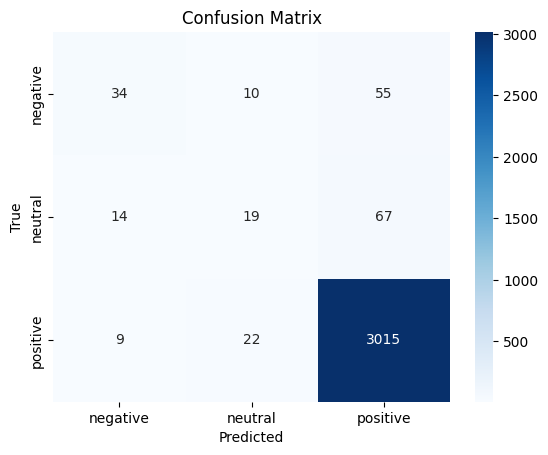

Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.34      0.44        99
     neutral       0.37      0.19      0.25       100
    positive       0.96      0.99      0.98      3046

    accuracy                           0.95      3245
   macro avg       0.64      0.51      0.55      3245
weighted avg       0.93      0.95      0.94      3245



In [128]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Embedding, Concatenate, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_model2 = df.dropna(subset=['text', 'stars', 'approval_rating', 'user_reputation', 'reply_count', 'best_score'])
df_model2 = df_model2[df_model2['stars'].between(0, 5)]

# Map stars to sentiment
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

df_model2['sentiment'] = df_model2['stars'].apply(map_star_to_sentiment)

# Encode sentiment labels
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df_model2['sentiment_encoded'] = df_model2['sentiment'].map(label_mapping)

# Extract features and labels
texts = df_model2['text'].astype(str).tolist()
approval_ratings = df_model2['approval_rating'].tolist()
user_reputations = df_model2['user_reputation'].tolist()
reply_counts = df_model2['reply_count'].tolist()
best_scores = df_model2['best_score'].tolist()
labels = df_model2['sentiment_encoded'].tolist()

# Split data into training and testing sets
X_train_text, X_test_text, X_train_rating, X_test_rating, X_train_reputation, X_test_reputation, X_train_reply, X_test_reply, X_train_score, X_test_score, y_train, y_test = train_test_split(
    texts, approval_ratings, user_reputations, reply_counts, best_scores, labels, test_size=0.2, random_state=42
)

# Tokenize and pad text data
vocab_size_model2 = 5000
max_seq_len_model2 = 100

tokenizer_model2 = Tokenizer(num_words=vocab_size_model2)
tokenizer_model2.fit_on_texts(texts)

X_train_seq_model2 = tokenizer_model2.texts_to_sequences(X_train_text)
X_test_seq_model2 = tokenizer_model2.texts_to_sequences(X_test_text)

X_train_padded_model2 = pad_sequences(X_train_seq_model2, maxlen=max_seq_len_model2, padding='post')
X_test_padded_model2 = pad_sequences(X_test_seq_model2, maxlen=max_seq_len_model2, padding='post')

# Normalize numerical features
X_train_rating_model2 = np.array(X_train_rating).reshape(-1, 1) / 100.0  # Normalize to 0-1 range
X_test_rating_model2 = np.array(X_test_rating).reshape(-1, 1) / 100.0
X_train_reputation_model2 = np.array(X_train_reputation).reshape(-1, 1) / df_model2['user_reputation'].max()
X_test_reputation_model2 = np.array(X_test_reputation).reshape(-1, 1) / df_model2['user_reputation'].max()
X_train_reply_model2 = np.array(X_train_reply).reshape(-1, 1) / df_model2['reply_count'].max()
X_test_reply_model2 = np.array(X_test_reply).reshape(-1, 1) / df_model2['reply_count'].max()
X_train_score_model2 = np.array(X_train_score).reshape(-1, 1) / df_model2['best_score'].max()
X_test_score_model2 = np.array(X_test_score).reshape(-1, 1) / df_model2['best_score'].max()

# Combine numerical features
X_train_numerical_model2 = np.hstack((X_train_rating_model2, X_train_reputation_model2, X_train_reply_model2, X_train_score_model2))
X_test_numerical_model2 = np.hstack((X_test_rating_model2, X_test_reputation_model2, X_test_reply_model2, X_test_score_model2))

# Define the model with hyperparameter tuning
def build_model(hp):
    text_input = Input(shape=(max_seq_len_model2,), name="text_input")
    embedding = Embedding(
        input_dim=vocab_size_model2,
        output_dim=hp.Int("embedding_dim", min_value=64, max_value=128, step=64),  # Reduced range
        input_length=max_seq_len_model2
    )(text_input)
    conv = Conv1D(
        filters=hp.Int("filters", min_value=32, max_value=64, step=32),  # Reduced range
        kernel_size=hp.Choice("kernel_size", values=[3, 5]),  # Fewer options
        activation="relu"
    )(embedding)
    pool = GlobalMaxPooling1D()(conv)

    # Numerical features input
    numerical_input = Input(shape=(4,), name="numerical_input")
    combined = Concatenate()([pool, numerical_input])

    # Fully connected layers
    fc1 = Dense(hp.Int("units", min_value=64, max_value=128, step=64), activation="relu")(combined)  # Reduced range
    dropout = Dropout(hp.Float("dropout", min_value=0.1, max_value=0.3, step=0.1))(fc1)  # Reduced range
    output = Dense(3, activation="softmax", name="output")(dropout)

    model = Model(inputs=[text_input, numerical_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, sampling="log")  # Narrow range
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

import tempfile

# Use a temporary writable directory for Keras Tuner
temp_dir = tempfile.gettempdir()

# Create the tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=5,  # Reduced epochs
    factor=4,  # Increased reduction factor to reduce trials
    directory=temp_dir,  # Temporary directory for tuner data
    project_name="cnn_tuning_model2"
)

# Perform hyperparameter search with a subset of data
subset_size = len(X_train_padded_model2) // 2  # Use 50% of the training data
tuner.search(
    [X_train_padded_model2[:subset_size], X_train_numerical_model2[:subset_size]],
    np.array(y_train[:subset_size]),
    validation_split=0.2,
    epochs=5,  # Reduced epochs
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)]  # Short patience
)

# Perform hyperparameter search with a subset of data
subset_size = len(X_train_padded_model2) // 2  # Use 50% of the training data
tuner.search(
    [X_train_padded_model2[:subset_size], X_train_numerical_model2[:subset_size]],
    np.array(y_train[:subset_size]),
    validation_split=0.2,
    epochs=5,  # Reduced epochs
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)]  # Short patience
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal embedding dimension is {best_hps.get('embedding_dim')},
with {best_hps.get('filters')} filters, kernel size of {best_hps.get('kernel_size')},
{best_hps.get('units')} units in the dense layer, dropout of {best_hps.get('dropout')},
and learning rate of {best_hps.get('learning_rate')}.
""")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    [X_train_padded_model2, X_train_numerical_model2],
    np.array(y_train),
    validation_split=0.2,
    epochs=5,  # Reduced epochs
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)]
)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(
    [X_test_padded_model2, X_test_numerical_model2], 
    np.array(y_test)
)
print(f"Test Accuracy: {test_accuracy}")

# Predictions
y_pred = np.argmax(best_model.predict([X_test_padded_model2, X_test_numerical_model2]), axis=1)

# Compute macro F1-score
macro_f1 = f1_score(y_test, y_pred, average="macro")
print(f"Macro F1-Score: {macro_f1}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

1. Data Preprocessing

Features:

1.	Text Features:
	•	Tokenized into sequences of word indices using a Tokenizer.
	•	Padded to a fixed length (max_seq_len_model2 = 100) for uniform input dimensions.
	•	Encoded as dense word vectors using an embedding layer.

2.	Numerical Features:
	•	Includes approval ratings, user reputation, reply count, and best score.
	•	Normalized to the range [0, 1].

Labels:
	•	Sentiment Encoding:
	•	Maps star ratings to sentiment categories (negative, neutral, positive).
	•	Converts sentiment categories into integer labels (0, 1, 2).

Data Splitting:
	•	The dataset is split into training and testing sets (80% train, 20% test).

2. Model Architecture

The model consists of two input branches: one for textual features and one for numerical features.

Text Input Branch:
1.	Embedding Layer:
	•	Converts word indices into dense vectors.
	•	Hyperparameter: embedding_dim (searches values between 64 and 128 during tuning).

2.	1D Convolutional Layer:
	•	Applies convolutional filters over the embedded text to extract local patterns.
	•	Hyperparameters:
	•	filters: Number of filters (searches values between 32 and 64).
	•	kernel_size: Size of the convolutional kernel (searches values [3, 5]).
	•	Output Shape: (batch_size, max_seq_len_model2 - kernel_size + 1, filters).

3.	Global Max Pooling:
	•	Reduces the feature maps into a fixed-length vector by taking the maximum value across each feature map.

Numerical Input Branch:
	•	Receives the normalized numerical features directly.
	•	Input Shape: (batch_size, 4) (one feature for each numerical input).

Combined Features:
1.	Concatenation:
	•	Combines the textual and numerical features into a single vector.

2.	Fully Connected (Dense) Layer:
	•	Learns complex interactions between combined features.
	•	Hyperparameters:
	•	units: Number of neurons in the dense layer (searches values between 64 and 128).
	•	Activation: ReLU.

3.	Dropout:
	•	Regularizes the dense layer by randomly deactivating neurons during training.
	•	Hyperparameter: dropout (searches values between 0.1 and 0.3).

4.	Output Layer:
	•	Fully connected layer with 3 neurons (one for each sentiment class: negative, neutral, positive).
	•	Activation: Softmax (outputs class probabilities).

4. Training Workflow

Early Stopping:
	•	Monitors validation loss and stops training if no improvement is observed for 2 consecutive epochs.
	•	Restores the best model weights after stopping.

Training Parameters:
	•	Number of epochs: 5.
	•	Validation split: 20% of training data.
	
Subset for Hyperparameter Tuning:
	•	Uses 50% of the training data to reduce computational cost during tuning.

Evaluation Metrics

Macro F1 Score:
	•	Balances precision and recall across all sentiment classes.
	•	Treats all classes equally, making it suitable for imbalanced datasets.

Classification Report:
	•	Provides precision, recall, and F1-score for each sentiment class.

Confusion Matrix:
	•	Visualizes the true vs. predicted sentiment labels for each class.

Workflow Steps
1.	Data Preparation:
	•	Processes text and numerical features.
	•	Splits the dataset into training and testing sets.

2.	Hyperparameter Tuning:
	•	Searches for the best combination of hyperparameters using Keras Tuner.

3.	Model Training:
	•	Trains the best model on the full training set.

4.	Evaluation:
	•	Computes macro F1 score, generates a classification report, and plots a confusion matrix.

## Based on Star Ratings

### Bag of Words

Test F1 Score: 0.8165
Classification Report:
              precision    recall  f1-score   support

      1-Star       0.39      0.27      0.32        55
      2-Star       0.07      0.02      0.03        44
      3-Star       0.32      0.21      0.25       100
      4-Star       0.33      0.19      0.24       305
      5-Star       0.89      0.96      0.92      2741

    accuracy                           0.84      3245
   macro avg       0.40      0.33      0.36      3245
weighted avg       0.80      0.84      0.82      3245



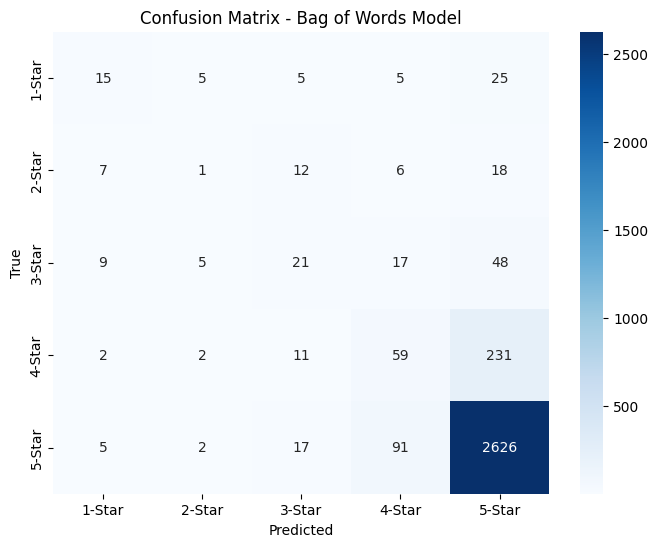

In [129]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter missing or invalid rows
bow_df = df.dropna(subset=['text', 'stars'])
bow_df = bow_df[bow_df['stars'].between(0, 5)]  # Ensure stars range is 1-5

# Step 2: Preprocess text and labels
bow_texts = bow_df['text'].astype(str)
bow_labels = bow_df['stars'] - 1  # Convert labels to 0-based indexing

# Step 3: Split into train and test sets
bow_X_train, bow_X_test, bow_y_train, bow_y_test = train_test_split(
    bow_texts, bow_labels, test_size=0.2, random_state=42
)

# Step 4: Vectorize the text data using Bag of Words
vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 words
bow_X_train_vec = vectorizer.fit_transform(bow_X_train)
bow_X_test_vec = vectorizer.transform(bow_X_test)

# Step 5: Train a Logistic Regression model
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(bow_X_train_vec, bow_y_train)

# Step 6: Make predictions
bow_y_pred = classifier.predict(bow_X_test_vec)

# Step 7: Evaluate the model
f1 = f1_score(bow_y_test, bow_y_pred, average='weighted')
print(f"Test F1 Score: {f1:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(bow_y_test, bow_y_pred, target_names=[f"{i+1}-Star" for i in range(5)]))

# Confusion Matrix
cm = confusion_matrix(bow_y_test, bow_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f"{i+1}-Star" for i in range(5)], yticklabels=[f"{i+1}-Star" for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Bag of Words Model')
plt.show()

### Bigrams and Trigrams by Sentiment Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top Bigrams and Trigrams for 'negative' Sentiment:
way much: 19
cream cheese: 11
sour cream: 11
waste time: 11
way sweet: 11
brown sugar: 10
throw away: 10
wont making: 10
much better: 9
apple pie: 8

Top Bigrams and Trigrams for 'neutral' Sentiment:
cream cheese: 17
brown sugar: 16
sour cream: 14
much better: 13
didnt care: 11
ground beef: 11
salt pepper: 10
also used: 9
first time: 9
cup sugar: 8

Top Bigrams and Trigrams for 'positive' Sentiment:
sour cream: 434
first time: 416
family loved: 403
banana bread: 378
ive made: 373
cream cheese: 328
family love: 304
everyone loved: 291
brown sugar: 288
also used: 283


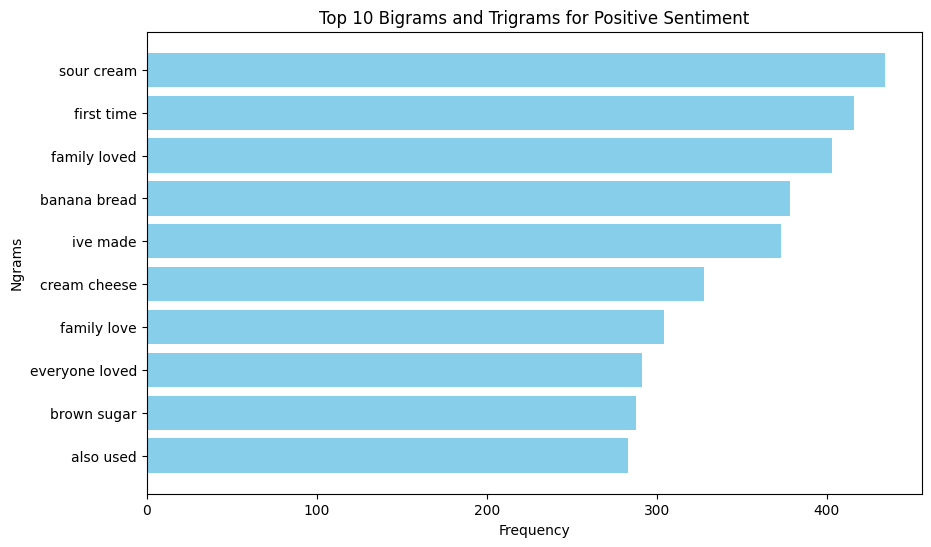

In [130]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import re

# Step 1: Ensure you have the necessary NLTK stopwords installed
import nltk
nltk.download('stopwords')

# Step 2: Define a custom stopword list
stop_words = set(stopwords.words('english'))
# Extend with custom stop words and common contractions
additional_stop_words = {'39', 've', 'don', 'll', 'didn', 'doesn', 'wasn', 'won', 'like', 'make', 'good', 'recipe', 'followed', 'next time'}
stop_words.update(additional_stop_words)

# Step 3: Preprocessing function to clean text
def clean_text(text):
    """
    Cleans text by removing punctuation, lowercasing, and filtering stopwords.
    """
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabetic characters
    words = text.lower().split()
    return " ".join([word for word in words if word not in stop_words])

# Step 4: Clean the text data for sentiment analysis
df_model2['cleaned_text'] = df_model2['text'].astype(str).apply(clean_text)

# Step 5: Function for extracting bigrams and trigrams
def get_ngrams(corpus, ngram_range=(2, 3), top_n=20):
    """
    Extract top n bigrams and trigrams from the corpus.

    Args:
    - corpus (list of str): Text data
    - ngram_range (tuple): Range of ngrams to extract (e.g., (2, 3) for bigrams and trigrams)
    - top_n (int): Number of top ngrams to return

    Returns:
    - Counter: Counter object with top ngrams and their frequencies
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    ngram_matrix = vectorizer.fit_transform(corpus)
    ngram_counts = ngram_matrix.sum(axis=0).A1
    ngram_vocab = vectorizer.get_feature_names_out()
    ngram_counter = Counter(dict(zip(ngram_vocab, ngram_counts)))
    # Remove 'next time' ngram
    ngram_counter = Counter({key: count for key, count in ngram_counter.items() if 'next time' not in key})
    return ngram_counter.most_common(top_n)

# Step 6: Generate bigrams and trigrams for each sentiment label
for sentiment in sorted(df_model2['sentiment'].unique()):
    sentiment_texts = df_model2[df_model2['sentiment'] == sentiment]['cleaned_text']
    print(f"\nTop Bigrams and Trigrams for '{sentiment}' Sentiment:")
    top_ngrams = get_ngrams(sentiment_texts, ngram_range=(2, 3), top_n=10)
    for ngram, count in top_ngrams:
        print(f"{ngram}: {count}")

# Step 7 (Optional): Visualize ngrams for a specific sentiment
def plot_ngrams(sentiment_label, ngram_range=(2, 3), top_n=10):
    """
    Plot the top ngrams for a specific sentiment.

    Args:
    - sentiment_label (str): The sentiment label to filter on ('negative', 'neutral', or 'positive')
    - ngram_range (tuple): Range of ngrams to extract
    - top_n (int): Number of top ngrams to visualize
    """
    sentiment_texts = df_model2[df_model2['sentiment'] == sentiment_label]['cleaned_text']
    top_ngrams = get_ngrams(sentiment_texts, ngram_range=ngram_range, top_n=top_n)
    
    # Prepare data for plotting
    ngrams, counts = zip(*top_ngrams)
    plt.figure(figsize=(10, 6))
    plt.barh(ngrams, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Ngrams')
    plt.title(f'Top {top_n} Bigrams and Trigrams for {sentiment_label.capitalize()} Sentiment')
    plt.gca().invert_yaxis()
    plt.show()

# Example: Plot for 'positive' sentiment
plot_ngrams(sentiment_label='positive', ngram_range=(2, 3), top_n=10)

# Time Series Models

### Display all Recipes List

In [131]:
from IPython.display import display
from IPython.display import HTML

# Get the value counts of 'recipe_name' as a DataFrame
recipe_counts = df['recipe_name'].value_counts().reset_index()
recipe_counts.columns = ['Recipe Name', 'Count']

# Convert the DataFrame to a scrollable HTML element
html_table = recipe_counts.to_html(index=False)
scrollable_table = f"""
<div style="height:400px; overflow:auto; border:1px solid black; padding:10px;">
{html_table}
</div>
"""

# Display the scrollable table
display(HTML(scrollable_table))

Recipe Name,Count
Cheeseburger Soup,642
Creamy White Chili,539
Best Ever Banana Bread,482
Favorite Chicken Potpie,364
Flavorful Chicken Fajitas,344
Basic Homemade Bread,326
Zucchini Pizza Casserole,324
Amish Breakfast Casserole,320
Cauliflower Soup,308
Enchilada Casser-Ole!,288


## SARIMA & Prophet

### Forecasting Sentiment

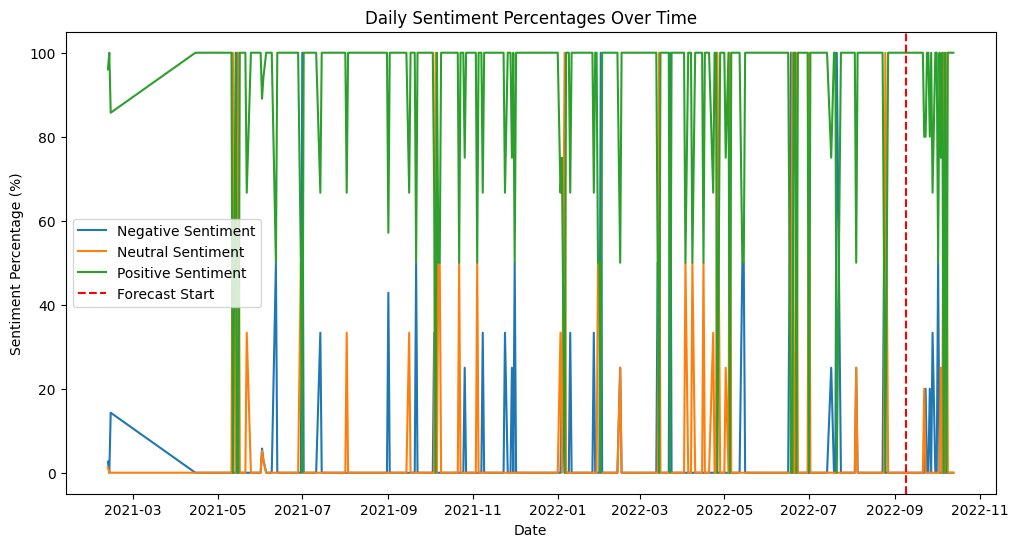

14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/t

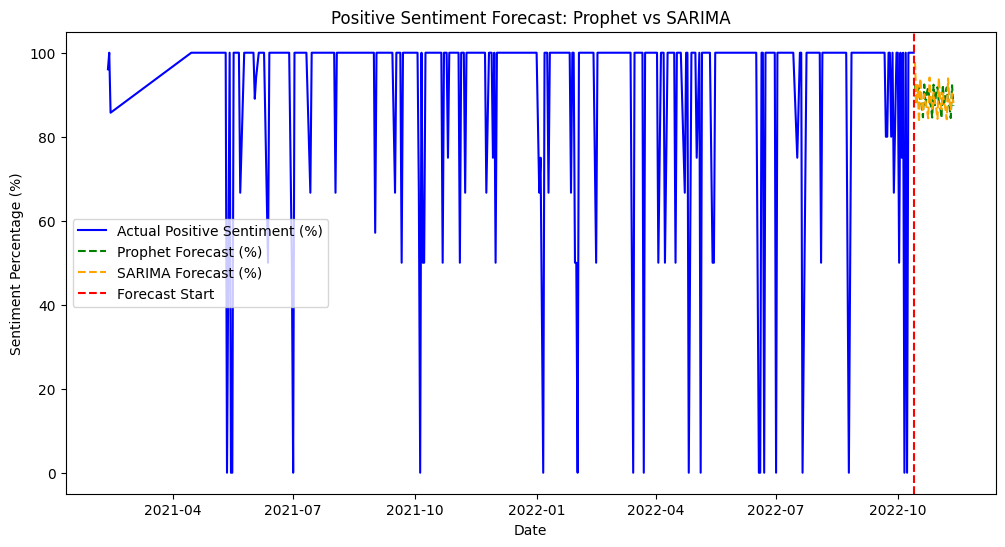


Positive Sentiment Forecast (Next 30 Days):
      Date  Prophet Forecast (%)  SARIMA Forecast (%)
2022-10-14             92.500591            97.780571
2022-10-15             87.620792            87.821348
2022-10-16             90.583701            92.301302
2022-10-17             91.922234            83.477319
2022-10-18             88.320901            93.813706
2022-10-19             87.497143            88.161147
2022-10-20             84.627380            85.903487
2022-10-21             92.440402            90.133366
2022-10-22             87.560602            88.308862
2022-10-23             90.523512            86.491566
2022-10-24             91.862045            84.395310
2022-10-25             88.260711            94.095913
2022-10-26             87.436953            88.792168
2022-10-27             84.567191            86.673772
2022-10-28             92.380213            90.505885
2022-10-29             87.500413            88.179665
2022-10-30             90.463323     

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Step 1: Parse 'created_at' column as datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Step 2: Map stars to sentiment
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

df['sentiment'] = df['stars'].apply(map_star_to_sentiment)

# Step 3: Aggregate data by sentiment proportions (daily)
daily_sentiment = df.groupby(pd.Grouper(key='created_at', freq='D'))['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Convert proportions to percentages for better readability
daily_sentiment *= 100

# Step 4: Plot time series for each sentiment
plt.figure(figsize=(12, 6))
for sentiment in daily_sentiment.columns:
    plt.plot(daily_sentiment.index, daily_sentiment[sentiment], label=f"{sentiment.capitalize()} Sentiment")
plt.axvline(daily_sentiment.index[-30], color='red', linestyle='--', label='Forecast Start')
plt.title('Daily Sentiment Percentages Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Percentage (%)')
plt.legend()
plt.show()

# Step 5: Prepare data for Prophet (example: 'positive' sentiment)
prophet_data_positive = daily_sentiment['positive'].reset_index().rename(columns={'created_at': 'ds', 'positive': 'y'})

# Step 6: Fit Prophet Model for 'positive' sentiment
positive_prophet_model = Prophet()
positive_prophet_model.fit(prophet_data_positive)

# Step 7: Make future predictions with Prophet
positive_future = positive_prophet_model.make_future_dataframe(periods=30)  # Forecast next 30 days
positive_forecast = positive_prophet_model.predict(positive_future)

# Extract Prophet forecasted values for the next 30 days
positive_forecast_next_30 = positive_forecast[['ds', 'yhat']].tail(30)
positive_forecast_next_30['yhat'] = positive_forecast_next_30['yhat'].clip(lower=0, upper=100)  # Ensure valid percentages

# Step 8: Use SARIMA for time series modeling on 'positive' sentiment
# Ensure the DataFrame uses the datetime index
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

# Fit SARIMA model for 'positive' sentiment with the corrected index
sarima_model_positive = SARIMAX(
    daily_sentiment['positive'], 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 7)  # Weekly seasonality
)
sarima_positive_result = sarima_model_positive.fit(disp=False)

# Forecast the next 30 days using SARIMA with proper datetime alignment
sarima_forecast_next_30_positive = sarima_positive_result.get_forecast(steps=30)

# Use the correct forecasted dates from the index
forecast_index = pd.date_range(
    start=daily_sentiment.index[-1] + pd.Timedelta(days=1), 
    periods=30, 
    freq='D'
)
sarima_forecast_summary_positive = sarima_forecast_next_30_positive.summary_frame()
sarima_forecast_summary_positive.index = forecast_index  # Align dates with the forecast

# Ensure the forecasts are clipped to valid percentages
sarima_forecast_summary_positive['mean'] = sarima_forecast_summary_positive['mean'].clip(lower=0, upper=100)

# Step 9: Plot combined actuals and forecasts
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment['positive'], label='Actual Positive Sentiment (%)', color='blue')
plt.plot(positive_forecast_next_30['ds'], positive_forecast_next_30['yhat'], label='Prophet Forecast (%)', linestyle='--', color='green')
plt.plot(sarima_forecast_summary_positive.index, sarima_forecast_summary_positive['mean'], label='SARIMA Forecast (%)', linestyle='--', color='orange')
plt.axvline(daily_sentiment.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Positive Sentiment Forecast: Prophet vs SARIMA')
plt.xlabel('Date')
plt.ylabel('Sentiment Percentage (%)')
plt.legend()
plt.show()

# Step 10: Combine Prophet and SARIMA forecasts into a summary table
forecast_summary_positive = pd.DataFrame({
    'Date': positive_forecast_next_30['ds'],
    'Prophet Forecast (%)': positive_forecast_next_30['yhat'],
    'SARIMA Forecast (%)': sarima_forecast_summary_positive['mean'].values
}).reset_index(drop=True)

# Print the summary table
print("\nPositive Sentiment Forecast (Next 30 Days):")
print(forecast_summary_positive.to_string(index=False))

# Step 11: Add inline commentary
print("\nInterpretation:")
print(f"Prophet predicts an average positive sentiment of {positive_forecast_next_30['yhat'].mean():.2f}% over the next 30 days.")
print(f"SARIMA predicts an average positive sentiment of {sarima_forecast_summary_positive['mean'].mean():.2f}% over the same period.")
print("Both models suggest relatively stable positive sentiment trends.")

This model uses time series analysis to predict the daily proportions of positive sentiment for reviews over the next 30 days, combining:
	1.	Prophet: A forecasting tool that handles seasonality and holidays.
	2.	SARIMA: A statistical model that accounts for trend, seasonality, and residuals.

1. Data Preparation

Key Steps:
1.	Convert Date Column:
	•	Converts the created_at column to a datetime format to enable time-based grouping and forecasting.

2.	Map Star Ratings to Sentiment:
	•	Maps star ratings into three sentiment categories:
	•	Negative: 1–2 stars.
	•	Neutral: 0 or 3 stars.
	•	Positive: 4–5 stars.

3.	Aggregate Sentiment Proportions:
	•	Calculates daily proportions of each sentiment category:
	•	Uses value_counts(normalize=True) to compute percentages for each sentiment on a given day.
	•	Fills missing values with 0 to maintain continuity.

4.	Convert Proportions to Percentages:
	•	Multiplies proportions by 100 for easier interpretation.


2. Visualization

Daily Sentiment Percentages:
	•	Plots time series of sentiment percentages for negative, neutral, and positive sentiments over time.
	•	Highlights the forecast start date using a vertical dashed red line.

3. Prophet Model

Steps:
1.	Prepare Prophet Input:
	•	Selects the positive sentiment percentages.
	•	Renames columns to match Prophet’s input format:
	•	ds: Datetime column.
	•	y: Target variable (positive sentiment percentages).

2.	Fit Prophet Model:
	•	Models the trend and seasonality of positive sentiment percentages over time.

3.	Forecast Future Sentiment:
	•	Predicts the next 30 days of positive sentiment percentages.
	•	Clips the forecast to ensure values stay within [0, 100].

Advantages:
	•	Captures long-term trends and seasonal effects.
	•	Automatically handles missing values.

4. SARIMA Model

Steps:
1.	Prepare Data for SARIMA:
	•	Uses the positive sentiment percentages with the corrected datetime index.

2.	Fit SARIMA Model:
	•	Configures the SARIMA model with:
	•	Trend Order: (1, 1, 1) for autoregressive, differencing, and moving average components.
	•	Seasonal Order: (1, 1, 1, 7) for weekly seasonality.

3.	Forecast Future Sentiment:
	•	Predicts the next 30 days of positive sentiment percentages.
	•	Clips the forecast to valid percentages [0, 100].

Advantages:
	•	Provides a strong statistical baseline for forecasting.
	•	Incorporates trend and seasonality explicitly.

5. Combined Forecasts

Steps:
1.	Plot Actuals and Forecasts:
	•	Plots:
	•	Actual daily positive sentiment percentages.
	•	Prophet forecast with dashed green lines.
	•	SARIMA forecast with dashed orange lines.

2.	Summary Table:
	•	Creates a table combining Prophet and SARIMA forecasts for each day in the next 30 days.

3.	Inline Commentary:
	•	Computes and prints the average predicted positive sentiment percentages for Prophet and SARIMA over the forecast period.

6. Outputs

Visualization:
	•	Time Series Plot:
	•	Shows actual positive sentiment percentages.
	•	Includes Prophet and SARIMA forecasts.
	•	Highlights the start of the forecast period with a red dashed line.

Summary Table:
	•	Displays daily forecasts for the next 30 days from both Prophet and SARIMA models.

Inline Commentary:
	•	Interprets the forecast results:
	•	Average positive sentiment percentage predicted by Prophet.
	•	Average positive sentiment percentage predicted by SARIMA.
	•	Observations about trends and stability.

### Forecasting Sentiment for Specific Recipe

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_2182/4136892063.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipe_df['sentiment'] = recipe_df['stars'].apply(map_star_to_sentiment)


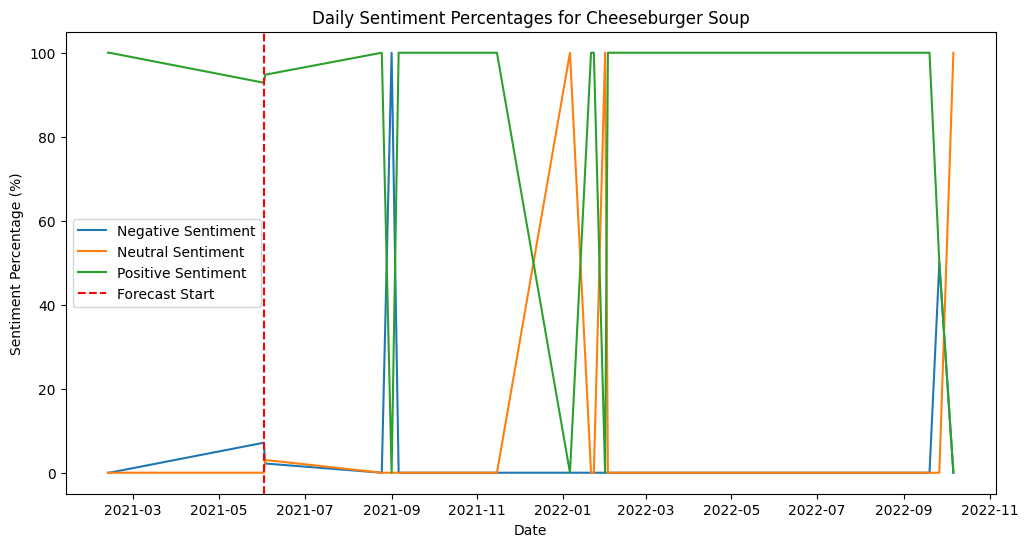

14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/michaelnguyen/Library/Python/3.9/lib/python/site-packages/statsmodels/t

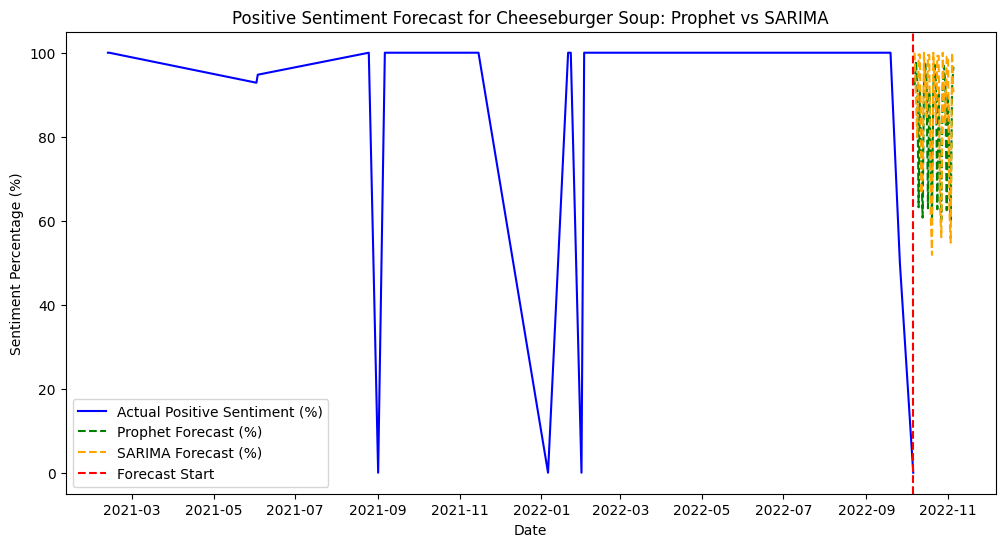


Positive Sentiment Forecast for Cheeseburger Soup (Next 30 Days):
      Date  Prophet Forecast (%)  SARIMA Forecast (%)
2022-10-07             92.259548           100.000000
2022-10-08             97.599247            89.208529
2022-10-09             93.134548            79.869662
2022-10-10             63.198391            99.590192
2022-10-11             90.955963            99.590520
2022-10-12             75.243761            66.463491
2022-10-13             60.738506            69.541693
2022-10-14             92.025414           100.000000
2022-10-15             97.365113            91.720615
2022-10-16             92.900415            84.683640
2022-10-17             62.964258            99.460745
2022-10-18             90.721829            99.460956
2022-10-19             75.009628            62.103316
2022-10-20             60.504373            51.873055
2022-10-21             91.791280           100.000000
2022-10-22             97.130979            90.858519
2022-10-23     

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Step 1: Parse 'created_at' column as datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Step 2: Filter for a specific recipe
specific_recipe_name = 'Cheeseburger Soup'  # Change this to your desired recipe
recipe_df = df[df['recipe_name'] == specific_recipe_name]

# Step 3: Map stars to sentiment
def map_star_to_sentiment(stars):
    if stars == 0:  # Mark 0 stars as neutral
        return "neutral"
    elif stars <= 2:  # 1 and 2 stars as negative
        return "negative"
    elif stars == 3:  # 3 stars as neutral
        return "neutral"
    else:  # 4 or 5 stars as positive
        return "positive"

recipe_df['sentiment'] = recipe_df['stars'].apply(map_star_to_sentiment)

# Step 4: Aggregate data by sentiment proportions (daily)
daily_sentiment_recipe = recipe_df.groupby(pd.Grouper(key='created_at', freq='D'))['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Convert proportions to percentages for better readability
daily_sentiment_recipe *= 100

# Step 5: Plot time series for each sentiment
plt.figure(figsize=(12, 6))
for sentiment in daily_sentiment_recipe.columns:
    plt.plot(daily_sentiment_recipe.index, daily_sentiment_recipe[sentiment], label=f"{sentiment.capitalize()} Sentiment")
plt.axvline(daily_sentiment_recipe.index[-30], color='red', linestyle='--', label='Forecast Start')
plt.title(f'Daily Sentiment Percentages for {specific_recipe_name}')
plt.xlabel('Date')
plt.ylabel('Sentiment Percentage (%)')
plt.legend()
plt.show()

# Step 6: Prepare data for Prophet (example: 'positive' sentiment)
prophet_data_positive_recipe = daily_sentiment_recipe['positive'].reset_index().rename(columns={'created_at': 'ds', 'positive': 'y'})

# Step 7: Fit Prophet Model for 'positive' sentiment
positive_prophet_model_recipe = Prophet()
positive_prophet_model_recipe.fit(prophet_data_positive_recipe)

# Step 8: Make future predictions with Prophet
positive_future_recipe = positive_prophet_model_recipe.make_future_dataframe(periods=30)  # Forecast next 30 days
positive_forecast_recipe = positive_prophet_model_recipe.predict(positive_future_recipe)

# Extract Prophet forecasted values for the next 30 days
positive_forecast_next_30_recipe = positive_forecast_recipe[['ds', 'yhat']].tail(30)
positive_forecast_next_30_recipe['yhat'] = positive_forecast_next_30_recipe['yhat'].clip(lower=0, upper=100)  # Ensure valid percentages

# Step 9: Use SARIMA for time series modeling on 'positive' sentiment
# Ensure the DataFrame uses the datetime index
daily_sentiment_recipe.index = pd.to_datetime(daily_sentiment_recipe.index)

# Fit SARIMA model for 'positive' sentiment with the corrected index
sarima_model_positive_recipe = SARIMAX(
    daily_sentiment_recipe['positive'], 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 7)  # Weekly seasonality
)
sarima_positive_result_recipe = sarima_model_positive_recipe.fit(disp=False)

# Forecast the next 30 days using SARIMA with proper datetime alignment
sarima_forecast_next_30_positive_recipe = sarima_positive_result_recipe.get_forecast(steps=30)

# Use the correct forecasted dates from the index
forecast_index_recipe = pd.date_range(
    start=daily_sentiment_recipe.index[-1] + pd.Timedelta(days=1), 
    periods=30, 
    freq='D'
)
sarima_forecast_summary_positive_recipe = sarima_forecast_next_30_positive_recipe.summary_frame()
sarima_forecast_summary_positive_recipe.index = forecast_index_recipe  # Align dates with the forecast

# Ensure the forecasts are clipped to valid percentages
sarima_forecast_summary_positive_recipe['mean'] = sarima_forecast_summary_positive_recipe['mean'].clip(lower=0, upper=100)

# Step 10: Plot combined actuals and forecasts
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment_recipe.index, daily_sentiment_recipe['positive'], label='Actual Positive Sentiment (%)', color='blue')
plt.plot(positive_forecast_next_30_recipe['ds'], positive_forecast_next_30_recipe['yhat'], label='Prophet Forecast (%)', linestyle='--', color='green')
plt.plot(sarima_forecast_summary_positive_recipe.index, sarima_forecast_summary_positive_recipe['mean'], label='SARIMA Forecast (%)', linestyle='--', color='orange')
plt.axvline(daily_sentiment_recipe.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title(f'Positive Sentiment Forecast for {specific_recipe_name}: Prophet vs SARIMA')
plt.xlabel('Date')
plt.ylabel('Sentiment Percentage (%)')
plt.legend()
plt.show()

# Step 11: Combine Prophet and SARIMA forecasts into a summary table
forecast_summary_positive_recipe = pd.DataFrame({
    'Date': positive_forecast_next_30_recipe['ds'],
    'Prophet Forecast (%)': positive_forecast_next_30_recipe['yhat'],
    'SARIMA Forecast (%)': sarima_forecast_summary_positive_recipe['mean'].values
}).reset_index(drop=True)

# Print the summary table
print(f"\nPositive Sentiment Forecast for {specific_recipe_name} (Next 30 Days):")
print(forecast_summary_positive_recipe.to_string(index=False))

# Step 12: Add inline commentary
print("\nInterpretation:")
print(f"Prophet predicts an average positive sentiment of {positive_forecast_next_30_recipe['yhat'].mean():.2f}% over the next 30 days for {specific_recipe_name}.")
print(f"SARIMA predicts an average positive sentiment of {sarima_forecast_summary_positive_recipe['mean'].mean():.2f}% over the same period.")
print("Both models suggest relatively stable positive sentiment trends.")

### Forecast Specific Recipe Star Ratings


Recent Star Ratings for Cheeseburger Soup:
              created_at  stars
1163 2022-10-06 16:59:51      3
1164 2022-09-26 12:19:30      2
1165 2022-09-26 03:52:04      5
1166 2022-09-19 14:11:42      5
1167 2022-09-09 23:38:21      5
1168 2022-09-02 19:29:12      5
1169 2022-08-28 07:26:01      5
1170 2022-08-04 00:51:08      5
1171 2022-07-30 08:44:38      5
1172 2022-05-17 22:43:11      5


/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_2182/80804065.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'], errors='coerce')


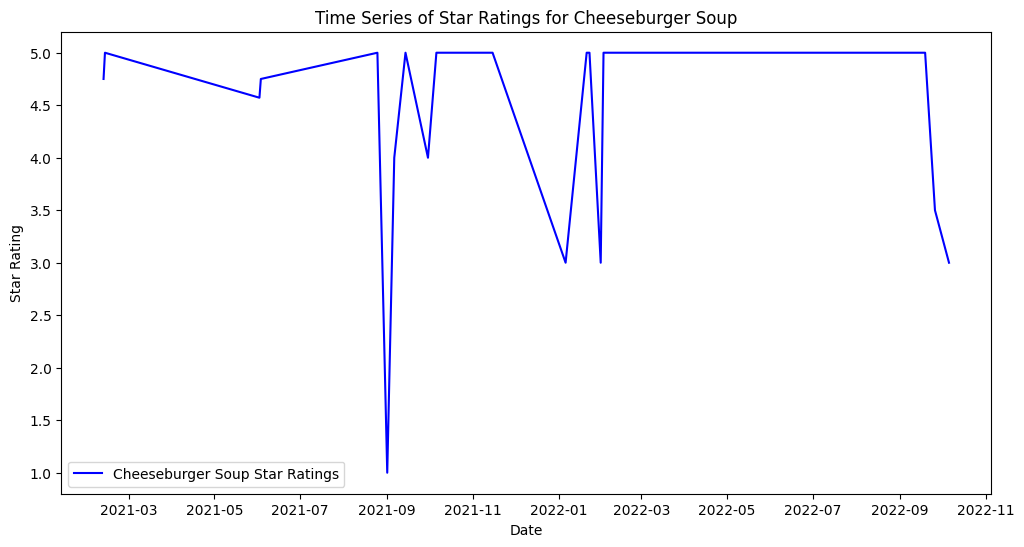

14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing


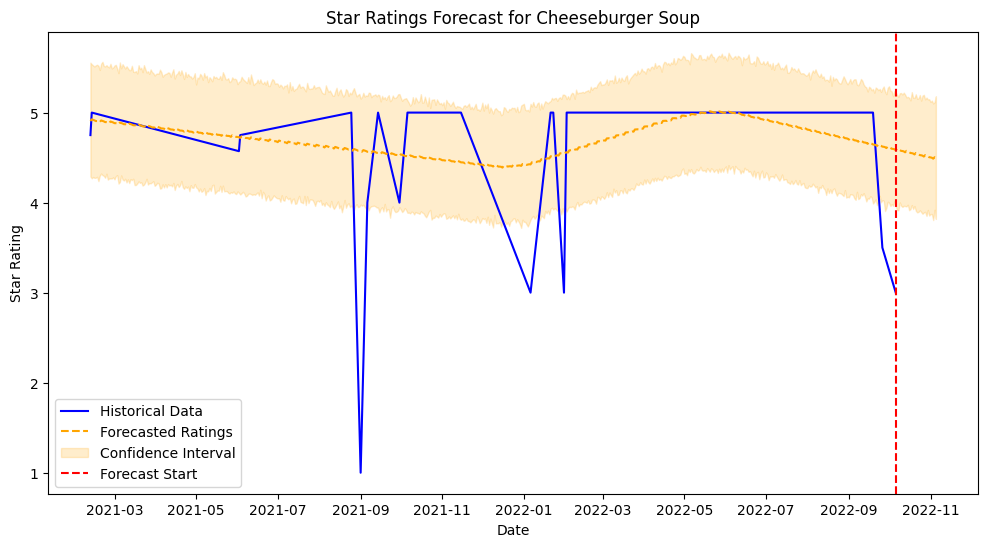

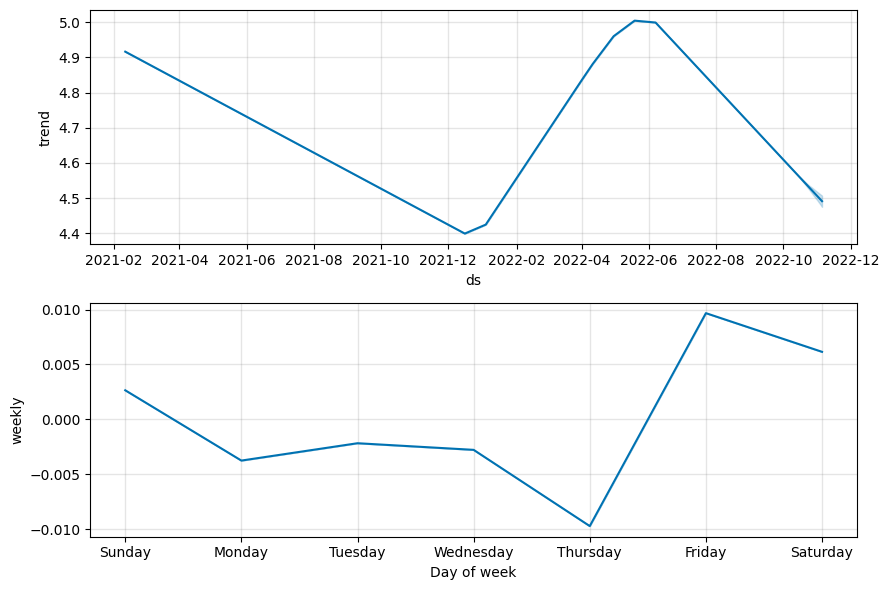


Forecasted Ratings
      Date  Predicted Star Rating  Lower Confidence Bound  Upper Confidence Bound
2022-10-07               4.598316                3.918141                5.197460
2022-10-08               4.591425                3.914135                5.174873
2022-10-09               4.584555                4.002446                5.215319
2022-10-10               4.574783                3.965614                5.217411
2022-10-11               4.572996                3.951699                5.201064
2022-10-12               4.569025                3.964586                5.221652
2022-10-13               4.558714                3.962141                5.200453
2022-10-14               4.574745                3.957794                5.168427
2022-10-15               4.567854                3.976324                5.175249
2022-10-16               4.560984                3.915272                5.165102
2022-10-17               4.551213                3.927136                5.135

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Step 1: Filter dataset for a specific recipe
recipe_name_filter = "Cheeseburger Soup"
filtered_df = df[df['recipe_name'] == recipe_name_filter]

# Ensure the filtered DataFrame is not empty
if filtered_df.empty:
    raise ValueError(f"No data available for the recipe: {recipe_name_filter}")

# Inspect recent data trends
print(f"\nRecent Star Ratings for {recipe_name_filter}:")
print(filtered_df[['created_at', 'stars']].sort_values(by='created_at', ascending=False).head(10))

# Step 2: Parse 'created_at' column as datetime
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'], errors='coerce')
filtered_df = filtered_df.dropna(subset=['created_at'])  # Drop rows with invalid dates

# Step 3: Aggregate data by date (e.g., daily mean of 'stars')
recipe_ts = (
    filtered_df.groupby(pd.Grouper(key='created_at', freq='D'))['stars']
    .mean()
    .reset_index()
)

# Ensure there are no missing dates and fill gaps
recipe_ts['stars'] = recipe_ts['stars'].interpolate().fillna(0)

# Step 4: Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(recipe_ts['created_at'], recipe_ts['stars'], label=f'{recipe_name_filter} Star Ratings', color='blue')
plt.title(f'Time Series of Star Ratings for {recipe_name_filter}')
plt.xlabel('Date')
plt.ylabel('Star Rating')
plt.legend()
plt.show()

# Step 5: Prepare data for Prophet
prophet_data = recipe_ts.rename(columns={'created_at': 'ds', 'stars': 'y'})

# Step 6: Fit Prophet model
recipe_prophet_model = Prophet()
recipe_prophet_model.fit(prophet_data)

# Step 7: Make future predictions
future = recipe_prophet_model.make_future_dataframe(periods=30)
forecast = recipe_prophet_model.predict(future)

# Step 8: Rename the forecast columns for clarity (after Prophet operations)
forecast_renamed = forecast.rename(columns={
    'ds': 'Date',
    'yhat': 'Predicted Star Rating',
    'yhat_lower': 'Lower Confidence Bound',
    'yhat_upper': 'Upper Confidence Bound'
})

# Step 9: Plot the forecast with forecasted values highlighted
plt.figure(figsize=(12, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Data', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Ratings', color='orange', linestyle='--')
plt.fill_between(
    forecast['ds'], 
    forecast['yhat_lower'], 
    forecast['yhat_upper'], 
    color='orange', 
    alpha=0.2, 
    label='Confidence Interval'
)
plt.axvline(x=prophet_data['ds'].iloc[-1], color='red', linestyle='--', label='Forecast Start')
plt.title(f"Star Ratings Forecast for {recipe_name_filter}")
plt.xlabel('Date')
plt.ylabel('Star Rating')
plt.legend()
plt.show()

# Step 10: Seasonal decomposition (keep 'ds' column for Prophet compatibility)
fig2 = recipe_prophet_model.plot_components(forecast)
plt.show()

clear_forecasted_ratings = forecast_renamed[['Date', 'Predicted Star Rating', 'Lower Confidence Bound', 'Upper Confidence Bound']].tail(30)
print("\nForecasted Ratings")
print(clear_forecasted_ratings.to_string(index=False))